<a href="https://colab.research.google.com/github/Yasushiy/intro_git/blob/master/%E3%80%90%E7%AC%AC4%E5%9B%9E_Beginner%E9%99%90%E5%AE%9A%E3%82%B3%E3%83%B3%E3%83%9A%E3%80%91%E8%87%AA%E5%8B%95%E8%BB%8A%E3%81%AE%E8%B5%B0%E8%A1%8C%E8%B7%9D%E9%9B%A2%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# このnotebookについて

## はじめに
*   このnotebookは2020年の11月にSIGNATEのコンペティションに参加した時のものです。　　　　　　　　　　　　　　

・参考URL：https://signate.jp/competitions/355
*   初心者限定のコンペティションではありますが、最終的な私の順位は295人中20位でした。

*   SIGNATEの規約に基づき、提供されたデータを基にした作成物をお見せすることは可能ですが、データ自体は直接お渡しする事が出来ません。何卒ご了承のほどお願い致します。 

*   試行錯誤の後も見ていただきたいと思い、本来なら不要な予測精度に貢献しなかった処理についても残しています。お見苦しいとは思いますが、何卒ご容赦下さいませ。




## コンペティションの概要


*   ８つの特徴量から自動車のガソリン１ガロンあたりの走行距離を予測するのが目的です。

*   トレーニングデータは10列×500行、テストデータは9列×500行の小さなデータになります。

*   評価指標は**RMSE**です。

*   コンペ一位の方のスコアは2.5375491です。私のベストスコアは2.5965710でした。




# 処理フロー


1.   ライブラリとトレーニングデータ呼び出し

2.   EDAと欠損値埋め
3.   トレーニングデータ前処理
4.   トレーニングデータ学習
5.   テストデータ前処理
6.   テストデータ予測

※その他、試したものの最終的な結果に貢献しなかった分析手法も途中に挟んでいますが大まかな流れは上記のとおりです。

# 1.ライブラリとトレーニングデータ呼び出し

最初に、処理に必要なライブラリをここで呼び出します。

In [1]:
#PCAとクラスタリング用
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [5]:
#printを省略しない設定
np.set_printoptions(threshold=np.inf)

In [6]:
#カテゴリデータ用
from sklearn import preprocessing

google driveからトレーニングデータをロードします。

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
data = pd.read_csv('/content/drive/My Drive/自動車の走行距離予測コンペ/train.csv',)

データがちゃんと読み込まれたかを確認します。

In [9]:
data.head()

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,23.059782,6,140,110,2815,17.977429,80,1,dodge aspen
1,3,17.674521,8,350,150,4456,13.514535,72,1,dodge rampage
2,4,17.136353,8,302,140,2774,13.209912,79,1,mercury cougar brougham
3,7,22.664666,6,400,85,2190,15.196381,71,1,pontiac j2000 se hatchback
4,9,17.872018,8,429,220,2245,9.621400,70,1,ford galaxie 500


In [10]:
"""欠損は無いようですが特徴量のhorsepowerが
object型になっているので注意が必要そうです。"""
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            500 non-null    int64  
 1   mpg           500 non-null    float64
 2   cylinders     500 non-null    int64  
 3   displacement  500 non-null    int64  
 4   horsepower    500 non-null    object 
 5   weight        500 non-null    int64  
 6   acceleration  500 non-null    float64
 7   model year    500 non-null    int64  
 8   origin        500 non-null    int64  
 9   car name      500 non-null    object 
dtypes: float64(2), int64(6), object(2)
memory usage: 39.2+ KB


# 2.EDA

## 概要
###・要約統計量の確認
###・各特徴量の把握
###・特徴量の分布を基にカテゴリデータを作成

In [11]:
# 最初に統計要約量を確認して、おおよその分布具合を想像します。
data.describe()

,id,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,500.176000,27.010940,5.192000,194.762000,2719.71400,15.300328,76.332000,1.420000
std,288.657179,7.356249,1.617519,106.277425,717.03541,2.261096,3.909007,0.759443
min,0.000000,15.787613,4.000000,79.000000,1755.00000,9.530859,70.000000,1.000000
25%,242.250000,22.396641,4.000000,104.000000,2178.75000,13.441562,73.000000,1.000000
50%,513.000000,26.228984,4.000000,140.000000,2615.00000,15.231923,76.000000,1.000000
75%,750.250000,35.088333,6.000000,302.000000,3193.00000,17.190531,80.000000,2.000000
max,997.000000,44.763897,8.000000,429.000000,4732.00000,21.922511,82.000000,3.000000


In [12]:
#モデル名が似ているデータの違いを見る

das = [data[data['car name'] == 'datsun 200-sx'], data[data['car name'] == 'datsun 200sx']] 
das

[      id        mpg  cylinders  ...  model year origin       car name
 15    32  35.066491          4  ...          82      1  datsun 200-sx
 99   189  27.805661          4  ...          82      2  datsun 200-sx
 135  273  27.343003          4  ...          82      1  datsun 200-sx
 221  448  28.485379          4  ...          82      2  datsun 200-sx
 344  694  17.091941          8  ...          70      1  datsun 200-sx
 369  739  16.275135          8  ...          70      1  datsun 200-sx
 389  776  35.776129          4  ...          82      2  datsun 200-sx
 414  829  28.310975          4  ...          82      2  datsun 200-sx
 443  881  28.080707          4  ...          82      2  datsun 200-sx
 485  967  28.087345          4  ...          82      2  datsun 200-sx
 495  981  22.798447          4  ...          82      1  datsun 200-sx
 
 [11 rows x 10 columns],
       id        mpg  cylinders  ...  model year origin      car name
 9     23  36.489563          4  ...          81   

mpg(目的変数)

Text(0, 0.5, 'car')

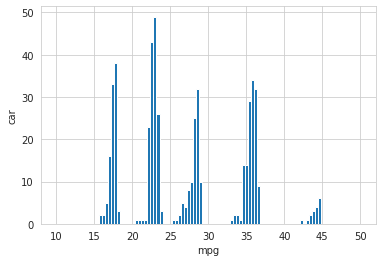

In [13]:
#まず目的変数のmpg（1マイル当たりの消費ガロン）を見ていきます。
#mpgは5つ分布の山が確認でき、分類が出来そうです。

plt.hist(data['mpg'], bins=100, range=(10,50))
plt.xlabel("mpg")
plt.ylabel("car")

In [14]:
"""ここではmpgを基に5グループに分けた場合、それぞれに何か特徴があるのか
観察します。"""

#グループ1
data[data['mpg'] < 20].append

#グループ2
#シリンダー6か4 オリジン1のみ？
data.query('20 <= mpg < 25')

#グループ3
#シリンダー4のみ？
data.query('25 <= mpg < 31')

#グループ4
#シリンダー4のみ？
data.query('31 <= mpg < 40')

#グループ5
#シリンダー4のみ？
data.query('40 <= mpg')

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
10,24,44.763897,4,85,?,1755,17.503013,80,2,renault lecar deluxe
33,72,44.033390,4,85,54,2190,20.650146,80,2,ford pinto
43,89,42.133089,4,305,148,2215,17.749508,82,2,mercury capri 2000
70,134,44.680084,4,258,69,4274,21.576805,72,2,volkswagen rabbit custom diesel
79,148,44.718427,4,90,69,4274,21.885688,78,2,amc ambassador dpl
94,180,43.745138,4,85,74,1755,17.349589,80,1,renault lecar deluxe
160,324,43.290837,4,140,112,2835,13.550609,82,1,amc gremlin
190,388,43.597728,4,305,110,3381,17.764962,82,2,amc gremlin
286,574,44.021790,4,85,?,1955,20.795175,80,2,pontiac astro
320,645,44.410105,4,85,?,1955,21.057837,80,2,pontiac astro


In [16]:
#ここではmpgを基にグループ分けしたことをカテゴリーデータとして特徴量に加えます。

mpg_group = []

for i in data['mpg']:
  if i < 20:
    mpg_group.append(0)
  elif 20 <= i < 25:
    mpg_group.append(1)
  elif 25 <= i < 31:
    mpg_group.append(2)
  elif 31 <= i < 40:
    mpg_group.append(3)    
  elif 40 <= i: 
    mpg_group.append(4)           
data[data['mpg'] < 20].append

data['mpg_group'] = mpg_group

In [17]:
#作成したmpg_groupをカテゴリ型にします。
data['mpg_group'] = data['mpg_group'].astype('category')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


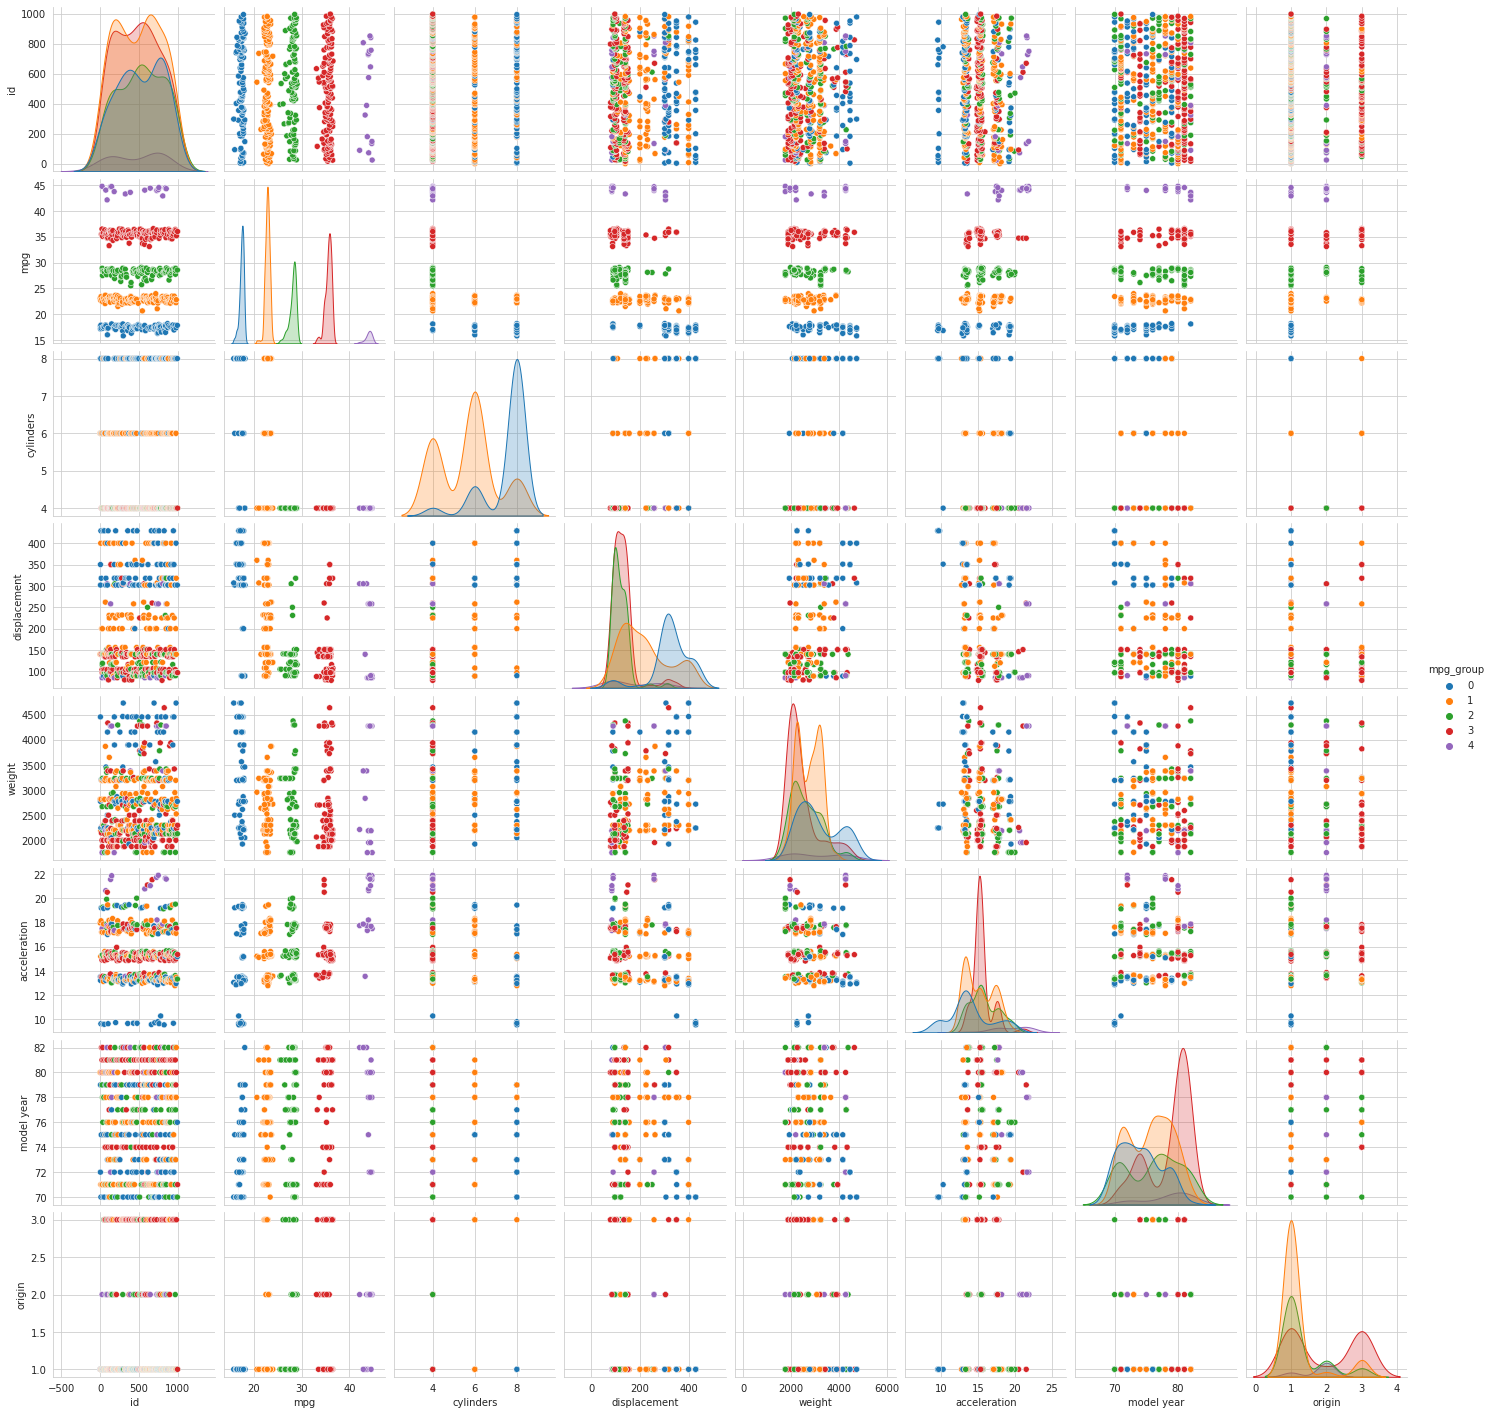

In [18]:
# さらにmpg_groupから知見を得るためペアプロット図を作成します。
sns.pairplot(data, hue='mpg_group')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


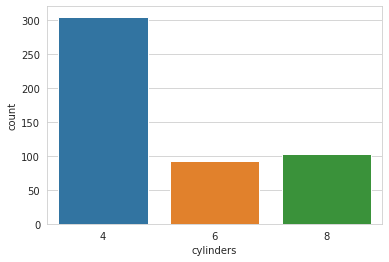

In [25]:
# 今度はデータのcylinders（シリンダーについて見ていきます。）
# グラフから車に搭載されるシリンダーの数は4、6、8の3パターンしかないことが分かります。
sns.countplot("cylinders",data=data)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


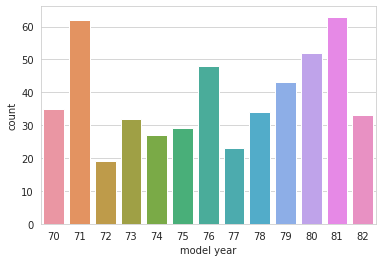

In [26]:
# model year(車の製造年)について見ていきます。
# 71年、81年製の車両が多いことに意味がありそうだと思いました。
sns.countplot("model year",data=data)

Text(0, 0.5, 'car')

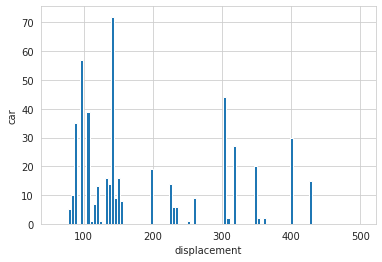

In [27]:
# displacement(排気量)についてです。
#排気量200の少し手前にデータが集中しています。190以下とその他で分けられそうです。 
#中央値が140なので全体の60％程度は排気量190以下ではないかと思いました。

plt.hist(data['displacement'], bins=100, range=(60,500))
plt.xlabel("displacement")
plt.ylabel("car")

In [22]:
# mpg同様に排気量についてもグループ分けします。

displacement_group = []

for i in data['displacement']:
  if i < 190:
    displacement_group.append(0)
  elif 190 <= i:
    displacement_group.append(1)

data['displacement_group'] = displacement_group

In [23]:
# displacement_groupをカテゴリ型に変換します。
data['displacement_group'] = data['displacement_group'].astype('category')

weight

Text(0, 0.5, 'car')

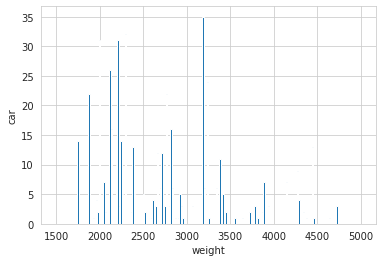

In [24]:
# weight(車両重量)について見ていきます。

plt.hist(data['weight'], bins=200, range=(1500,5000))
plt.xlabel("weight")
plt.ylabel("car")

In [28]:
""" 見えづらいですが分布の山が複数あるようにも思えます。
一応これについてもグループ分けしておきます。"""

weight_group = []

for i in data['weight']:
  if i < 2500:
    weight_group.append(0)
  elif 2500 <= i < 3000:
    weight_group.append(1)
  elif 3000 <= i < 4000:
    weight_group.append(2)    
  elif 4000 <= i: 
    weight_group.append(3)           


data['weight_group'] = weight_group

In [29]:
# カテゴリ型に変換します。
data['weight_group'] = data['weight_group'].astype('category')

acceleration

Text(0, 0.5, 'car')

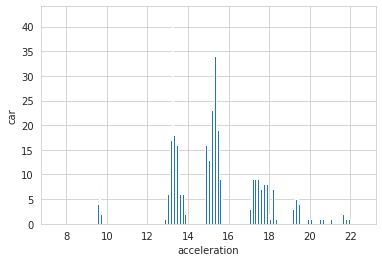

In [30]:
# acceleration(加速度)について見ていきます。
#これもいくつかのグループに分けられそうです。
# 加速度の数値の範囲が狭いことにも注意しておきます。

plt.hist(data['acceleration'], bins=200, range=(7.5,22.5))
plt.xlabel("acceleration")
plt.ylabel("car")

In [31]:
#加速度について11、14.5、16、19を境界線としてグループ分けします。

acceleration_group = []

for i in data['acceleration']:
  if i < 11:
    acceleration_group.append(0)
  elif 11 <= i < 14.5:
    acceleration_group.append(1)
  elif 14.5 <= i < 16:
    acceleration_group.append(2)    
  elif 14.5 <= i < 16:
    acceleration_group.append(3) 
  elif 16 <= i:
    acceleration_group.append(4)         


data['acceleration_group'] = acceleration_group

In [32]:
# カテゴリ型に変換します。
data['acceleration_group'] = data['acceleration_group'].astype('category')

horsepower

In [33]:
# horsepowerについて見ていく前に、object型である理由を探します。

#下記は数値型に変換できない要素があれば 'False' を返すコードです。
data[['id','cylinders',	'displacement',	'horsepower',	'weight',	'acceleration',	'model year',	'origin',	'car name']].apply(lambda s:pd.to_numeric(s, errors='coerce')).notnull().all()

id               True
cylinders        True
displacement     True
horsepower      False
weight           True
acceleration     True
model year       True
origin           True
car name        False
dtype: bool

In [34]:
# 数値型に変換できない要素の抽出
# 一部が'?'で埋められていることが分かりました。
hor = data[['horsepower']][data['horsepower'].apply(lambda s:pd.to_numeric(s, errors='coerce')).isnull()]
hor

,horsepower
10,?
48,?
224,?
286,?
320,?
407,?
415,?
455,?
487,?


In [35]:
"""上記の結果を参考に、10番目の行を表示させます。"""
data.iloc[487]

id                          970
mpg                      27.725
cylinders                     4
displacement                140
horsepower                    ?
weight                     1760
acceleration            19.5324
model year                   76
origin                        1
car name              vw rabbit
mpg_group                     2
displacement_group            0
weight_group                  0
acceleration_group            4
Name: 487, dtype: object

In [36]:
# 10行目のcar nameが'pontiac astro'なので、同じcar nameの他の車両を参考に表示します。
data[data['car name'] == 'vw rabbit']

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg_group,displacement_group,weight_group,acceleration_group
25,57,28.102213,4,98,60,1760,13.512347,71,1,vw rabbit,2,0,0,1
48,96,23.008702,4,140,?,1760,19.472427,76,1,vw rabbit,1,0,0,4
100,191,27.764627,4,140,120,2408,19.408774,73,1,vw rabbit,2,0,0,4
119,227,22.729533,4,232,95,3193,13.249940,71,1,vw rabbit,1,1,2,1
165,335,27.682178,4,140,72,2408,19.388988,71,1,vw rabbit,2,0,0,4
199,405,22.782539,4,140,108,2200,17.428149,71,1,vw rabbit,1,0,0,4
202,411,22.891049,6,400,96,2200,13.222813,71,1,vw rabbit,1,1,0,1
224,454,28.146944,4,140,?,1760,19.420540,76,1,vw rabbit,2,0,0,4
299,600,22.502001,4,140,72,1760,19.363757,71,1,vw rabbit,1,0,0,4
330,665,22.760164,4,140,120,1760,13.399325,71,1,vw rabbit,1,0,0,1


In [37]:
"""上の2つのセルのやり方で、他の'？'も似ている性能の車を探して埋めていきます
ポンティアックアストロはid24, 72, 180, 732, 756の性能が似てたので平均しました。"""

data.loc[data['id']==574, 'horsepower'] = 70
data.loc[data['id']==645, 'horsepower'] = 70

data.loc[data['id']==24, 'horsepower'] = 74
data.loc[data['id']==96, 'horsepower'] = 72
data.loc[data['id']==454, 'horsepower'] = 72
data.loc[data['id']==815, 'horsepower'] = 72
data.loc[data['id']==831, 'horsepower'] = 72
data.loc[data['id']==901, 'horsepower'] = 72
data.loc[data['id']==970, 'horsepower'] = 72

In [38]:
# horsepowerをint型に変換します。
data['horsepower'] = data['horsepower'].astype('int64')

Text(0, 0.5, 'car')

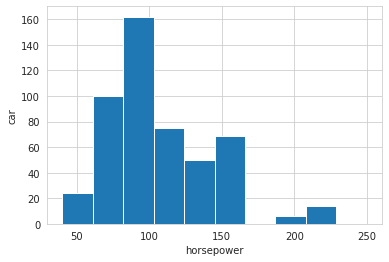

In [39]:
# 改めてhorsepowerを見ていきます。
plt.hist(data['horsepower'], bins=10, range=(40,250))
plt.xlabel("horsepower")
plt.ylabel("car")

In [40]:
# 175のあたりで区切れそうです。

horsepower_group = []

for i in data['horsepower']:
  if i < 175:
    horsepower_group.append(0)  
  elif 175 <= i: 
    horsepower_group.append(1)           


data['horsepower_group'] = horsepower_group

In [41]:
data['horsepower_group'] = data['horsepower_group'].astype('category')

origin

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


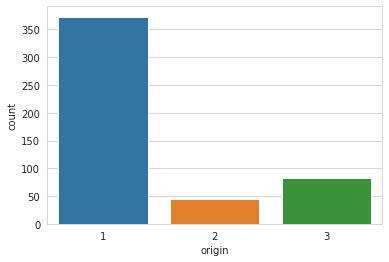

In [42]:
# originについて見ていきます。originがどんな特徴量なのかは分かりません。
# 1、2、3の値しかとらないのでカテゴリーデータと思われます。
sns.countplot('origin',data=data)

In [43]:
"""originは製造国が欧州日本米国のいずれかを表している思いました。
originが3のデータを抽出しましたがdatsu(日産)とビュイックが混ざっているのでこの推測は間違っていそうです。"""
data[data['origin'] == 3]

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg_group,displacement_group,weight_group,acceleration_group,horsepower_group
22,47,28.301643,4,140,88,2300,15.163064,78,3,buick century,2,0,0,2,0
27,59,36.317000,4,104,60,2123,14.864609,81,3,datsun 200sx,3,0,0,2,0
28,61,35.188597,4,134,100,2385,15.429557,74,3,datsun 210,3,0,0,2,0
31,69,35.487434,4,134,85,2391,15.471633,74,3,buick regal sport coupe (turbo),3,0,0,2,0
41,87,28.372570,4,90,75,2123,17.554040,81,3,capri ii,2,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,932,35.893920,4,134,85,2391,15.523660,74,3,buick regal sport coupe (turbo),3,0,0,2,0
469,933,35.223025,4,134,85,2391,15.428857,74,3,datsun 210 mpg,3,0,0,2,0
476,949,36.041754,4,104,60,2123,14.876446,81,3,datsun 200sx,3,0,0,2,0
486,968,36.403494,4,104,60,2123,14.918310,81,3,datsun 200sx,3,0,0,2,0


car name

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 720x360 with 0 Axes>

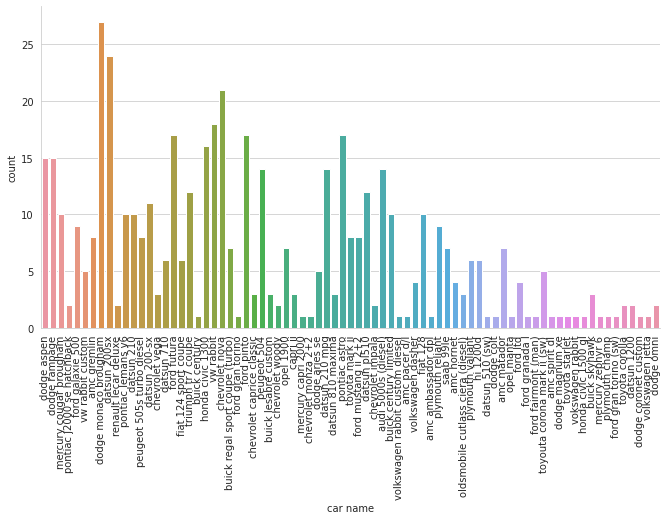

In [44]:
# car nameについて見ていきます
plt.figure(figsize=(10,5))
g = sns.factorplot("car name", data=data, aspect=2, kind="count") 
g.set_xticklabels(rotation=90)

In [45]:
#car nameは77種類あります。
data['car name'].unique()

array(['dodge aspen', 'dodge rampage', 'mercury cougar brougham',
       'pontiac j2000 se hatchback', 'ford galaxie 500',
       'vw rabbit custom', 'amc gremlin', 'dodge monaco brougham',
       'datsun 200sx', 'renault lecar deluxe', 'pontiac lemans v6',
       'datsun 210', 'peugeot 505s turbo diesel', 'datsun 200-sx',
       'chevrolet vega', 'datsun 710', 'ford futura',
       'fiat 124 sport coupe', 'triumph tr7 coupe', 'buick century',
       'honda civic 1300', 'vw rabbit', 'chevrolet nova',
       'buick regal sport coupe (turbo)', 'ford gran torino',
       'ford pinto', 'chevrolet caprice classic', 'peugeot 504',
       'buick lesabre custom', 'chevrolet woody', 'opel 1900', 'capri ii',
       'mercury capri 2000', 'chevrolet monza 2+2', 'dodge aries se',
       'datsun 210 mpg', 'datsun 810 maxima', 'pontiac astro',
       'toyota mark ii', 'ford mustang ii 2+2', 'datsun pl510',
       'chevrolet impala', 'audi 5000s (diesel)', 'buick century limited',
       'volkswagen r

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6304d4320>,
      dtype=object)

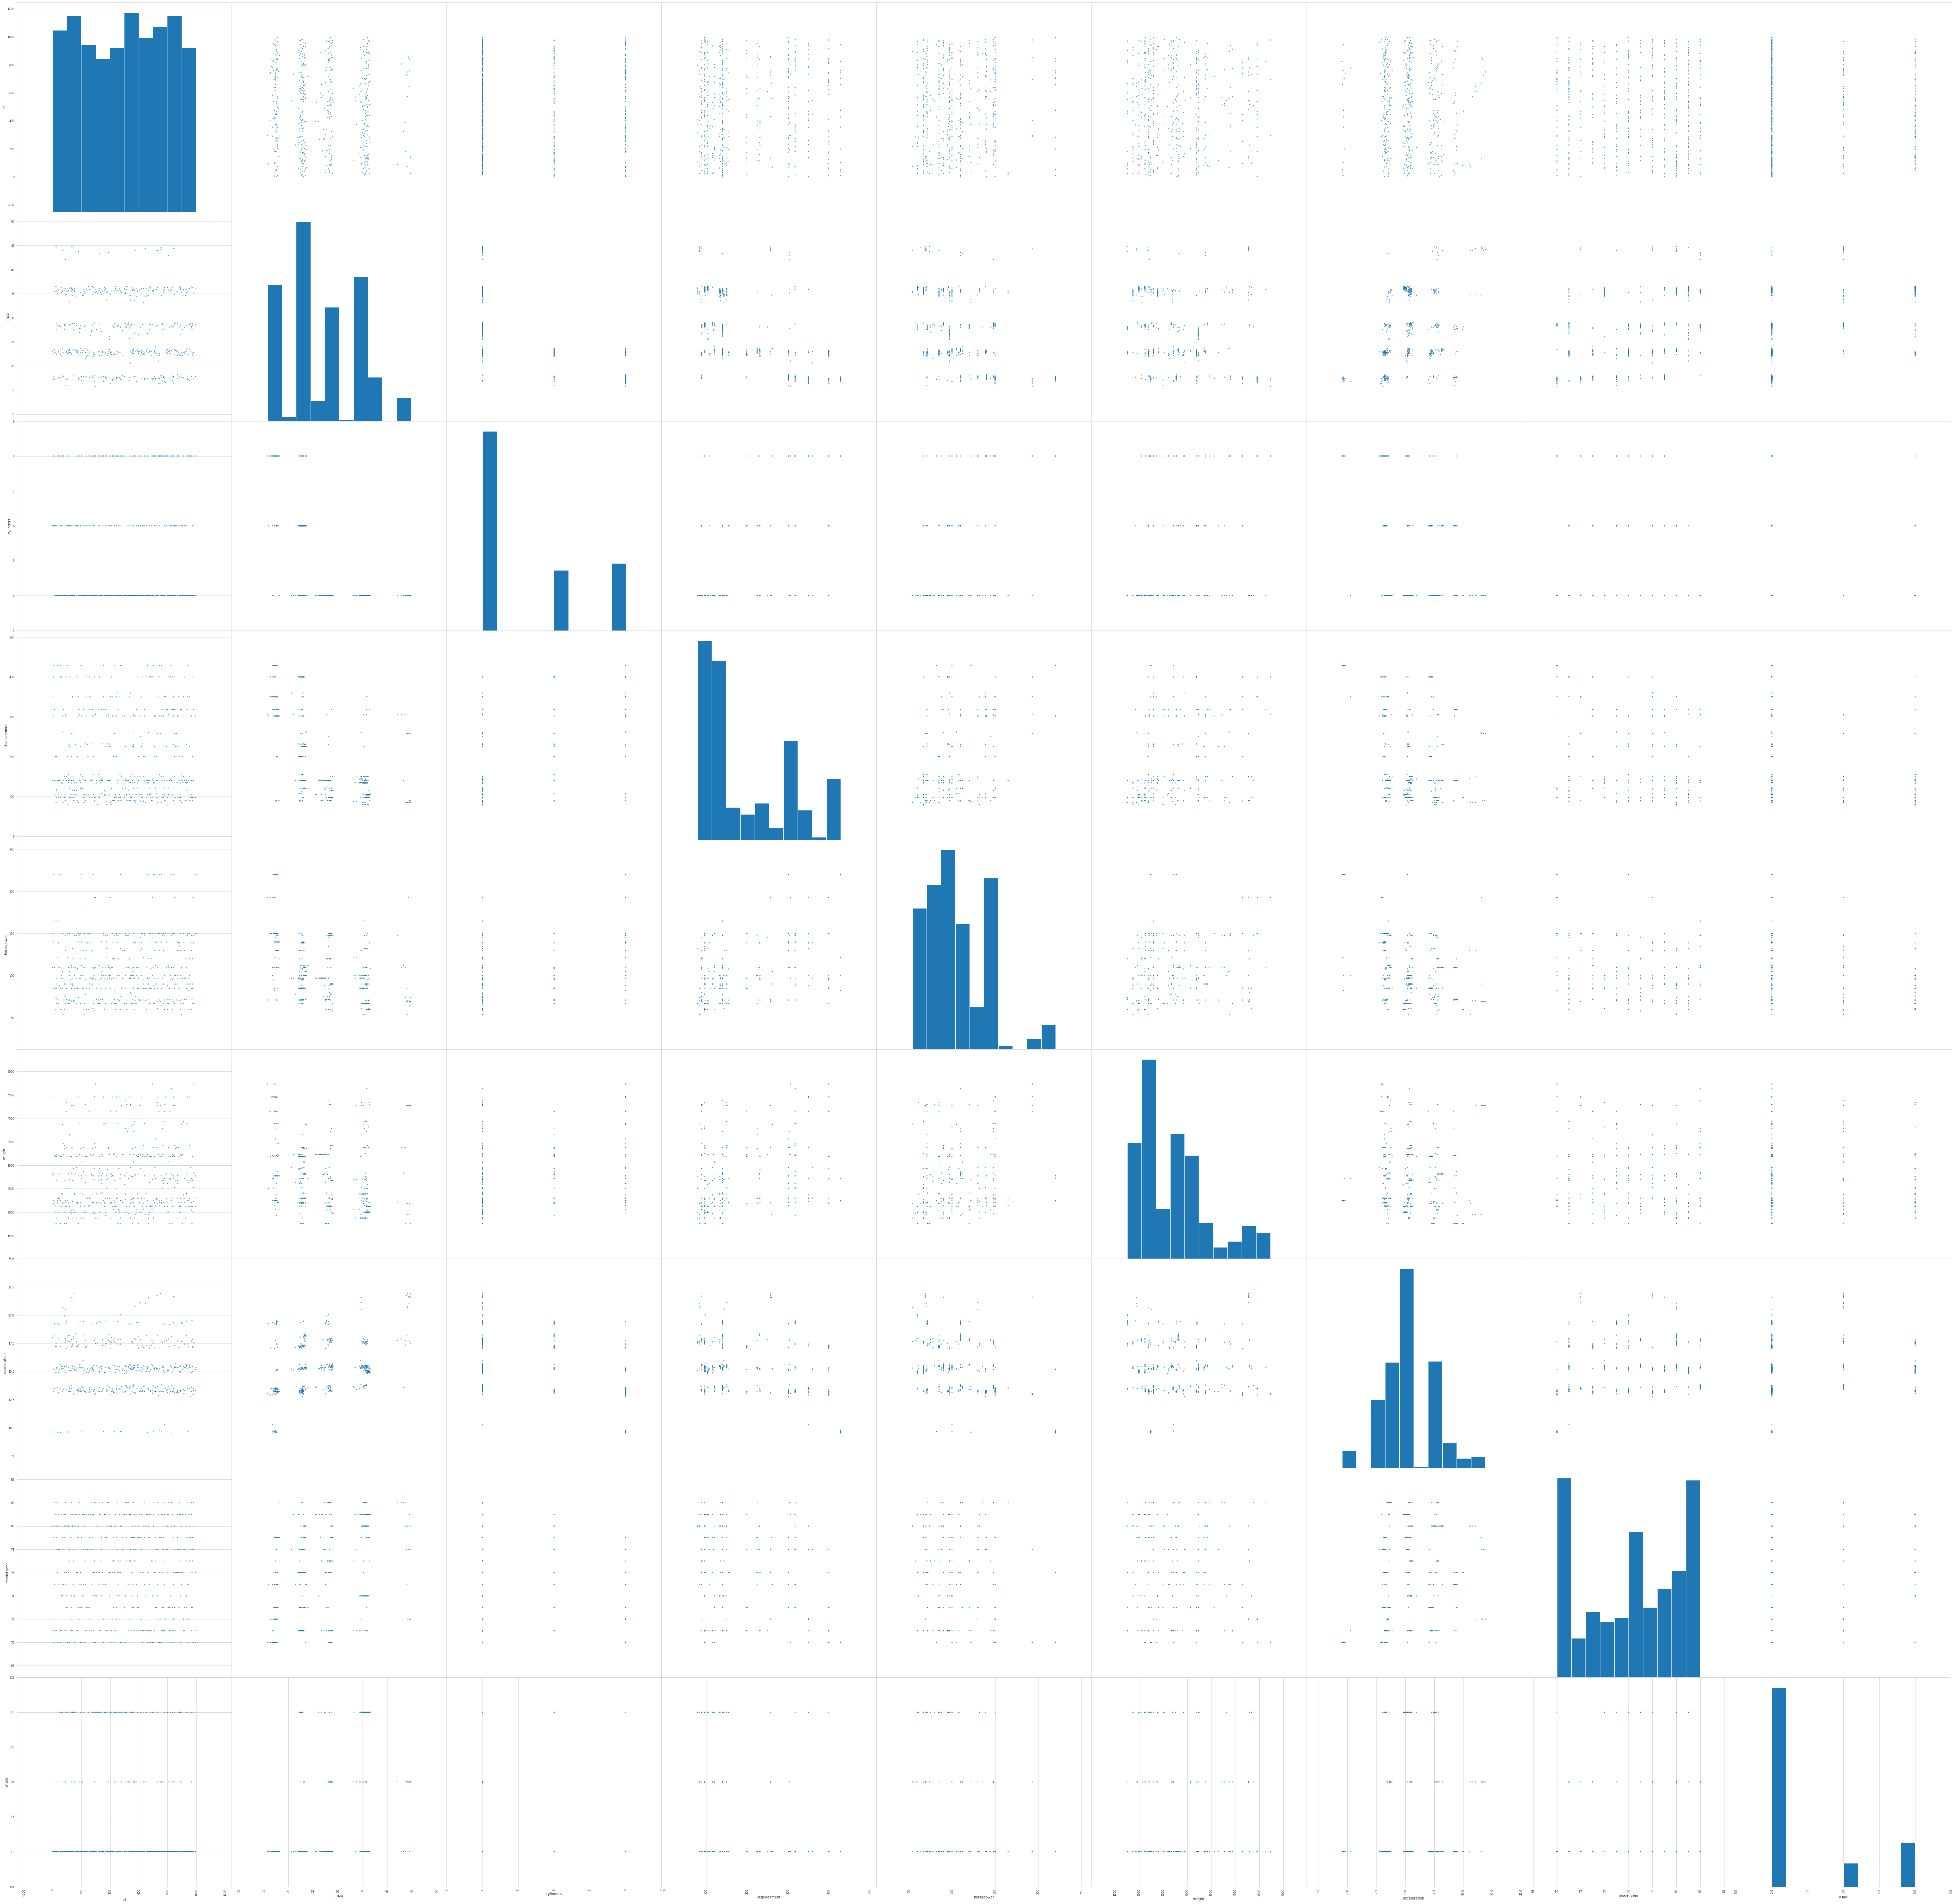

In [46]:
# 全ての特徴量を使ってペアプロット図を作成します。
pd.plotting.scatter_matrix(data, alpha=0.8, figsize=(100,100), range_padding=0.5)

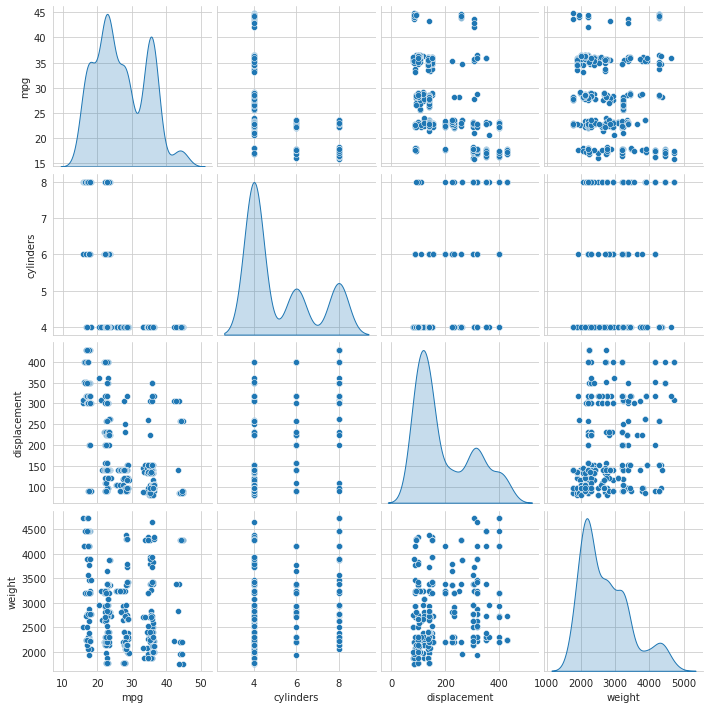

In [47]:
# 最後に重要だと思った特徴量のみで散布図を作成します。
sns.pairplot(data[["mpg", "cylinders", "displacement", "weight"]], diag_kind="kde")

# 3.トレーニングデータ前処理

## 概要
###・データの確認
###・特徴量の生成
###・名寄せ
###・対数変換

In [48]:
# 再度データの確認
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  500 non-null    int64   
 1   mpg                 500 non-null    float64 
 2   cylinders           500 non-null    int64   
 3   displacement        500 non-null    int64   
 4   horsepower          500 non-null    int64   
 5   weight              500 non-null    int64   
 6   acceleration        500 non-null    float64 
 7   model year          500 non-null    int64   
 8   origin              500 non-null    int64   
 9   car name            500 non-null    object  
 10  mpg_group           500 non-null    category
 11  displacement_group  500 non-null    category
 12  weight_group        500 non-null    category
 13  acceleration_group  500 non-null    category
 14  horsepower_group    500 non-null    category
dtypes: category(5), float64(2), int64(7), ob

In [49]:
# 欠損値をチェックします。
data.isnull().sum()

id                    0
mpg                   0
cylinders             0
displacement          0
horsepower            0
weight                0
acceleration          0
model year            0
origin                0
car name              0
mpg_group             0
displacement_group    0
weight_group          0
acceleration_group    0
horsepower_group      0
dtype: int64

新特徴量生成

In [50]:
# 特徴量同士を掛け合わせて新しい特徴量を作ります。


#馬力*加速度/重さ？微妙
ha_w = (data['horsepower'] * data['acceleration']) / data['weight']
#効果あり　#排気量*シリンダー
d_c = data['displacement'] / data['cylinders']
dc =data['displacement'] * data['cylinders'] 
#加速×重さ これはちがう
aw = data['acceleration'] / data['weight']
#シリンダー/ウェイト 効果あり
c_w =data['cylinders'] / data['weight']
cw =data['cylinders'] * data['weight']


#その他 効果は微妙
h_d = data['horsepower']/data['displacement']
hd = data['horsepower']*data['displacement']

#馬力とシリンダー
hc = data['horsepower'] * data['cylinders']
h_c= data['horsepower'] / data['cylinders'] #採用



data['ha_w'], data['d_c'], data['aw'], data['c_w'], data['dc'], data['cw'], data['h_d'],data['hd'], data['hc'], data['h_c'] = ha_w, d_c, aw, c_w, dc, cw, h_d, hd, hc, h_c


In [51]:
#上記と同じように新しい特徴量を作成しています。

dw = data['displacement'] * data['weight']
mo = data['model year'] * data['origin']
M_sm =-data['cylinders'] * data['model year']
M_so = -data['cylinders'] * data['origin']
M_dm = -data['displacement'] * data['model year']

data['dw'], data['mo'],  = dw, mo
data['M_sm'] = M_sm
data['M_so'] = M_so
data['M_dm'] = M_dm

In [52]:
data

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg_group,displacement_group,weight_group,acceleration_group,horsepower_group,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,M_sm,M_so,M_dm
0,0,23.059782,6,140,110,2815,17.977429,80,1,dodge aspen,1,0,1,4,0,0.702493,23.333333,0.006386,0.002131,840,16890,0.785714,15400,660,18.333333,394100,80,-480,-6,-11200
1,3,17.674521,8,350,150,4456,13.514535,72,1,dodge rampage,0,1,3,1,0,0.454933,43.750000,0.003033,0.001795,2800,35648,0.428571,52500,1200,18.750000,1559600,72,-576,-8,-25200
2,4,17.136353,8,302,140,2774,13.209912,79,1,mercury cougar brougham,0,1,1,1,0,0.666686,37.750000,0.004762,0.002884,2416,22192,0.463576,42280,1120,17.500000,837748,79,-632,-8,-23858
3,7,22.664666,6,400,85,2190,15.196381,71,1,pontiac j2000 se hatchback,1,1,0,2,0,0.589814,66.666667,0.006939,0.002740,2400,13140,0.212500,34000,510,14.166667,876000,71,-426,-6,-28400
4,9,17.872018,8,429,220,2245,9.621400,70,1,ford galaxie 500,0,1,0,0,1,0.942854,53.625000,0.004286,0.003563,3432,17960,0.512821,94380,1760,27.500000,963105,70,-560,-8,-30030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,981,22.798447,4,140,148,2835,13.477573,82,1,datsun 200-sx,1,0,1,1,0,0.703591,35.000000,0.004754,0.001411,560,11340,1.057143,20720,592,37.000000,396900,82,-328,-4,-11480
496,983,35.173640,4,97,67,2234,17.542681,80,3,plymouth valiant,3,0,0,4,0,0.526123,24.250000,0.007853,0.001791,388,8936,0.690722,6499,268,16.750000,216698,240,-320,-12,-7760
497,994,17.825448,8,302,220,2774,15.177189,76,1,triumph tr7 coupe,0,1,1,2,1,1.203670,37.750000,0.005471,0.002884,2416,22192,0.728477,66440,1760,27.500000,837748,76,-608,-8,-22952
498,995,28.545147,4,97,150,2130,13.324669,70,1,datsun pl510,2,0,0,1,0,0.938357,24.250000,0.006256,0.001878,388,8520,1.546392,14550,600,37.500000,206610,70,-280,-4,-6790


In [53]:
#　類似のcar nameを統一してみましたが、予測精度は上がりませんでした。

"""一見して似ている（同じ？）名前
'datsun 200-sx', 'datsun 200sx',　作られた年によって違う
'buick century',
       'buick century limited',　一緒にしていいかもしれない
'datsun 210', 'datsun 210 mpg'　これも

'datsun pl510'　'datsun 510 (sw)'　

'ford gran torino', 'ford gran torino (sw)'
'toyota corolla', 'toyota mark ii','toyouta corona mark ii (sw)'
'volkswagen rabbit custom diesel',, 'vw rabbit custom'],
'vokswagen rabbit''vw rabbit
datsun 1200, hi 1200? →　べつもの

data = data.replace('datsun 200-sx','datsun 200sx')

data['car name'].unique()

#.replace('buick century','buick century limited').replace('datsun pl510','datsun 510 (sw)').replace(
#'toyota corolla', 'toyota mark ii').replace('toyota mark ii','toyouta corona mark ii (sw)').replace('volkswagen rabbit custom diesel','vw rabbit custom').replace('vw rabbit custom','vokswagen rabbit')
###1107実験用 全部比較したけどだめ
###.replace('datsun 210','datsun 210 mpg').replace('ford gran torino', 'ford gran torino (sw)').replace('vw rabbit','vokswagen rabbit').replace('datsun 200-sx','datsun 200sx')
"""

"一見して似ている（同じ？）名前\n'datsun 200-sx', 'datsun 200sx',\u3000作られた年によって違う\n'buick century',\n       'buick century limited',\u3000一緒にしていいかもしれない\n'datsun 210', 'datsun 210 mpg'\u3000これも\n\n'datsun pl510'\u3000'datsun 510 (sw)'\u3000\n\n'ford gran torino', 'ford gran torino (sw)'\n'toyota corolla', 'toyota mark ii','toyouta corona mark ii (sw)'\n'volkswagen rabbit custom diesel',, 'vw rabbit custom'],\n'vokswagen rabbit''vw rabbit\ndatsun 1200, hi 1200? →\u3000べつもの\n\ndata = data.replace('datsun 200-sx','datsun 200sx')\n\ndata['car name'].unique()\n\n#.replace('buick century','buick century limited').replace('datsun pl510','datsun 510 (sw)').replace(\n#'toyota corolla', 'toyota mark ii').replace('toyota mark ii','toyouta corona mark ii (sw)').replace('volkswagen rabbit custom diesel','vw rabbit custom').replace('vw rabbit custom','vokswagen rabbit')\n###1107実験用 全部比較したけどだめ\n###.replace('datsun 210','datsun 210 mpg').replace('ford gran torino', 'ford gran torino (sw)').replace('vw rabbit','voksw

In [54]:
# car nameにdieselと表記されてるデータにディーゼルフラグを立てました。
# 該当データが3つしかないこともあり、精度に貢献しませんでした。

diesel_flag = []
for i in data['car name']:
  if i in 'diesel':
    diesel_flag.append(1)
  else:
    diesel_flag.append(0)    

data['diesel_flag'] = diesel_flag
#カテゴリー変数化
data['diesel_flag'] = data['diesel_flag'].astype('category')

In [55]:
# car nameの一部を取り出してメーカー名を特徴量とした列を作りました。
# さらにtoyouta(トヨウタ？)などの誤字も訂正しました。

df_spr = data['car name'].str.split(' ', expand=True)
data['maker'] = df_spr[0]
#メーカー名統一用　
data = data.replace('vw' , 'volkswagen').replace('vokswagen','volkswagen').replace('toyouta', 'toyota')
data['maker'].unique()

array(['dodge', 'mercury', 'pontiac', 'ford', 'volkswagen', 'amc',
       'datsun', 'renault', 'peugeot', 'chevrolet', 'fiat', 'triumph',
       'buick', 'honda', 'opel', 'capri', 'toyota', 'audi', 'plymouth',
       'saab', 'oldsmobile', 'hi'], dtype=object)

In [56]:
#カテゴリデータ同士をかけ合わせた特徴量を作りました。
data['name-origin'] = data['car name'] + '-' + data['origin'].astype(str)
data['maker-origin'] = data['car name'] + '-' + data['maker']
data['name-year'] = data['car name'] + '-' + data['model year'].astype(str)
data['name-cylinders'] = data['car name'] + '-' + data['cylinders'].astype(str)
data['name-horsepower'] = data['car name'] + '-' + data['horsepower'].astype(str)
#保留、考え方はあり
#data['name-origin'] = data['maker'] + '-' + data['cylinder'].astype(str) + '-' + data['displacement']

In [57]:
# カテゴリ型に変換する関数を作りました。
# 'cylinders'と'origin'をカテゴリ型に変換します。

def chenge_into_category(df, col_list):
    for col in col_list:
        df[col] = df[col].astype('category')
    return df
category_col = ['origin'] 
data = chenge_into_category(data, category_col)

In [59]:
# シリンダーは数値とカテゴリ両方の意味を持つと考えました。
# 数値型とカテゴリ型の両方保持します。

data['cylinders_c'] = data['cylinders'].astype('category')

In [62]:
# さっき作った特徴量同士を掛け合わせたものも関数を使って変換します。
category_col = ['name-origin','maker-origin','name-year','car name',
                'diesel_flag','maker','name-cylinders','name-horsepower'] 
data = chenge_into_category(data, category_col)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  500 non-null    int64   
 1   mpg                 500 non-null    float64 
 2   cylinders           500 non-null    int64   
 3   displacement        500 non-null    int64   
 4   horsepower          500 non-null    int64   
 5   weight              500 non-null    int64   
 6   acceleration        500 non-null    float64 
 7   model year          500 non-null    int64   
 8   origin              500 non-null    category
 9   car name            500 non-null    category
 10  mpg_group           500 non-null    category
 11  displacement_group  500 non-null    category
 12  weight_group        500 non-null    category
 13  acceleration_group  500 non-null    category
 14  horsepower_group    500 non-null    category
 15  ha_w                500 non-null    floa

In [64]:
#EDAの際に分布の裾が長く見えたものを一部対数化します。


#data['displacement_log'] =data['displacement'].apply(np.log)
data['weight_log'] =data['weight'].apply(np.log)
data['acceleration_log'] =data['acceleration'].apply(np.log)
#data['origin_log'] = data['origin'].apply(np.log)
#data['dw_log'] = data['dw'].apply(np.log)
#data['hc_log'] = data['hc'].apply(np.log)
#data['hd_log'] = data['hd'].apply(np.log)
#data['cw_log'] = data['cw'].apply(np.log)

In [65]:
data['weight_log']

0      7.942718
1      8.402007
2      7.928046
3      7.691657
4      7.716461
         ...   
495    7.949797
496    7.711549
497    7.928046
498    7.663877
499    7.740664
Name: weight_log, Length: 500, dtype: float64

重量四分位数

In [66]:
"""weightを四分位数毎に区切ってカテゴリ化しましたが、精度に貢献しませんでした。

weight_q = []

for i in data['weight']:
  if i 	<= 2178.75:
    weight_q.append(0)
  elif   2178.75 < i <= 2615:
    weight_q.append(1)
  elif   2615 < i <= 3193:
    weight_q.append(2)
  elif   3193 < i :
    weight_q.append(3) 

data['weight_q'] = weight_q       

data['weight_q'] = data['weight_q'].astype('category')"""

"weightを四分位数毎に区切ってカテゴリ化しましたが、精度に貢献しませんでした。\n\nweight_q = []\n\nfor i in data['weight']:\n  if i \t<= 2178.75:\n    weight_q.append(0)\n  elif   2178.75 < i <= 2615:\n    weight_q.append(1)\n  elif   2615 < i <= 3193:\n    weight_q.append(2)\n  elif   3193 < i :\n    weight_q.append(3) \n\ndata['weight_q'] = weight_q       \n\ndata['weight_q'] = data['weight_q'].astype('category')"

In [67]:
data.describe()

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,M_sm,M_so,M_dm,weight_log,acceleration_log
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,500.176000,27.010940,5.192000,194.762000,106.214000,2719.71400,15.300328,76.332000,0.611106,36.635083,0.005982,0.001984,1135.912000,14456.412000,0.662555,22473.816000,582.996000,21.243417,5.562891e+05,108.754000,-394.452000,-6.984000,-14710.704000,7.876395,2.716857
std,288.657179,7.356249,1.617519,106.277425,35.585121,717.03541,2.261096,3.909007,0.201580,15.031570,0.001695,0.000647,923.204565,6955.432198,0.313109,18360.698782,358.923787,6.680208,3.868817e+05,59.454884,117.799172,3.300535,7681.385721,0.248282,0.149623
min,0.000000,15.787613,4.000000,79.000000,54.000000,1755.00000,9.530859,70.000000,0.214979,11.250000,0.002738,0.000862,316.000000,7020.000000,0.167500,4590.000000,216.000000,8.375000,1.491750e+05,70.000000,-632.000000,-24.000000,-31200.000000,7.470224,2.254535
25%,242.250000,22.396641,4.000000,104.000000,82.000000,2178.75000,13.441562,73.000000,0.457102,26.000000,0.004730,0.001587,420.000000,8760.000000,0.443709,10080.000000,340.000000,16.750000,2.531250e+05,73.000000,-459.000000,-8.000000,-23214.000000,7.686466,2.598352
50%,513.000000,26.228984,4.000000,140.000000,97.000000,2615.00000,15.231923,76.000000,0.557139,35.000000,0.005953,0.001879,564.000000,12932.000000,0.615401,14550.000000,440.000000,18.750000,3.865500e+05,79.000000,-324.000000,-6.000000,-11200.000000,7.869019,2.723393
75%,750.250000,35.088333,6.000000,302.000000,130.000000,3193.00000,17.190531,80.000000,0.740483,38.541667,0.007009,0.002133,1812.000000,18070.000000,0.785714,34000.000000,660.000000,24.250000,8.115562e+05,142.000000,-308.000000,-4.000000,-8424.000000,8.068716,2.844359
max,997.000000,44.763897,8.000000,429.000000,220.000000,4732.00000,21.922511,82.000000,1.254199,100.000000,0.011378,0.003902,3432.000000,37856.000000,1.650000,94380.000000,1760.000000,48.250000,1.892800e+06,243.000000,-280.000000,-4.000000,-6248.000000,8.462103,3.087514


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  500 non-null    int64   
 1   mpg                 500 non-null    float64 
 2   cylinders           500 non-null    int64   
 3   displacement        500 non-null    int64   
 4   horsepower          500 non-null    int64   
 5   weight              500 non-null    int64   
 6   acceleration        500 non-null    float64 
 7   model year          500 non-null    int64   
 8   origin              500 non-null    category
 9   car name            500 non-null    category
 10  mpg_group           500 non-null    category
 11  displacement_group  500 non-null    category
 12  weight_group        500 non-null    category
 13  acceleration_group  500 non-null    category
 14  horsepower_group    500 non-null    category
 15  ha_w                500 non-null    floa

In [69]:
data

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg_group,displacement_group,weight_group,acceleration_group,horsepower_group,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,M_sm,M_so,M_dm,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,weight_log,acceleration_log
0,0,23.059782,6,140,110,2815,17.977429,80,1,dodge aspen,1,0,1,4,0,0.702493,23.333333,0.006386,0.002131,840,16890,0.785714,15400,660,18.333333,394100,80,-480,-6,-11200,0,dodge,dodge aspen-1,dodge aspen-dodge,dodge aspen-80,dodge aspen-6,dodge aspen-110,6,7.942718,2.889117
1,3,17.674521,8,350,150,4456,13.514535,72,1,dodge rampage,0,1,3,1,0,0.454933,43.750000,0.003033,0.001795,2800,35648,0.428571,52500,1200,18.750000,1559600,72,-576,-8,-25200,0,dodge,dodge rampage-1,dodge rampage-dodge,dodge rampage-72,dodge rampage-8,dodge rampage-150,8,8.402007,2.603766
2,4,17.136353,8,302,140,2774,13.209912,79,1,mercury cougar brougham,0,1,1,1,0,0.666686,37.750000,0.004762,0.002884,2416,22192,0.463576,42280,1120,17.500000,837748,79,-632,-8,-23858,0,mercury,mercury cougar brougham-1,mercury cougar brougham-mercury,mercury cougar brougham-79,mercury cougar brougham-8,mercury cougar brougham-140,8,7.928046,2.580967
3,7,22.664666,6,400,85,2190,15.196381,71,1,pontiac j2000 se hatchback,1,1,0,2,0,0.589814,66.666667,0.006939,0.002740,2400,13140,0.212500,34000,510,14.166667,876000,71,-426,-6,-28400,0,pontiac,pontiac j2000 se hatchback-1,pontiac j2000 se hatchback-pontiac,pontiac j2000 se hatchback-71,pontiac j2000 se hatchback-6,pontiac j2000 se hatchback-85,6,7.691657,2.721057
4,9,17.872018,8,429,220,2245,9.621400,70,1,ford galaxie 500,0,1,0,0,1,0.942854,53.625000,0.004286,0.003563,3432,17960,0.512821,94380,1760,27.500000,963105,70,-560,-8,-30030,0,ford,ford galaxie 500-1,ford galaxie 500-ford,ford galaxie 500-70,ford galaxie 500-8,ford galaxie 500-220,8,7.716461,2.263990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,981,22.798447,4,140,148,2835,13.477573,82,1,datsun 200-sx,1,0,1,1,0,0.703591,35.000000,0.004754,0.001411,560,11340,1.057143,20720,592,37.000000,396900,82,-328,-4,-11480,0,datsun,datsun 200-sx-1,datsun 200-sx-datsun,datsun 200-sx-82,datsun 200-sx-4,datsun 200-sx-148,4,7.949797,2.601027
496,983,35.173640,4,97,67,2234,17.542681,80,3,plymouth valiant,3,0,0,4,0,0.526123,24.250000,0.007853,0.001791,388,8936,0.690722,6499,268,16.750000,216698,240,-320,-12,-7760,0,plymouth,plymouth valiant-3,plymouth valiant-plymouth,plymouth valiant-80,plymouth valiant-4,plymouth valiant-67,4,7.711549,2.864637
497,994,17.825448,8,302,220,2774,15.177189,76,1,triumph tr7 coupe,0,1,1,2,1,1.203670,37.750000,0.005471,0.002884,2416,22192,0.728477,66440,1760,27.500000,837748,76,-608,-8,-22952,0,triumph,triumph tr7 coupe-1,triumph tr7 coupe-triumph,triumph tr7 coupe-76,triumph tr7 coupe-8,triumph tr7 coupe-220,8,7.928046,2.719794
498,995,28.545147,4,97,150,2130,13.324669,70,1,datsun pl510,2,0,0,1,0,0.938357,24.250000,0.006256,0.001878,388,8520,1.546392,14550,600,37.500000,206610,70,-280,-4,-6790,0,datsun,datsun pl510-1,datsun pl510-datsun,datsun pl510-70,datsun pl510-4,datsun pl510-150,4,7.663877,2.589617


# PCA(不採用)

PCA（主成分分析）で特徴量を削減し、予測精度向上と新たな知見の獲得を狙いましたが、上手くいきませんでした。

In [267]:
# n_components：削減結果の次元数
pca = PCA(n_components=2).fit(data.drop(['id','mpg', 'car name',
                                         'maker',	'name-origin',	'maker-origin',
                                         'name-year',	'name-cylinders',
                                         'name-horsepower'], axis=1))
# 主成分分析を実施
values = pca.transform(data.drop(['id','mpg', 'car name',
                                         'maker',	'name-origin',	'maker-origin',
                                         'name-year',	'name-cylinders',
                                         'name-horsepower'],axis=1))

In [268]:
print(values)

[[-1.62321858e+05 -1.06108019e+03]
 [ 1.00396554e+06 -9.13409530e+03]
 [ 2.82211145e+05  9.77322254e+03]
 [ 3.20055417e+05  9.64540271e+02]
 [ 4.09459031e+05  5.70528100e+04]
 [-1.62321858e+05 -1.06108020e+03]
 [ 4.63152365e+05 -4.73277500e+03]
 [-2.55860456e+05  1.03695950e+04]
 [ 8.20855469e+04 -8.81353545e+03]
 [-3.48769647e+05 -3.02054765e+03]
 [-4.07578714e+05 -8.86058585e+02]
 [-2.46936960e+05 -2.88744855e+03]
 [-3.74878596e+05 -1.82886407e+03]
 [ 8.20855469e+04 -8.81353545e+03]
 [-1.71925591e+05 -4.82893642e+03]
 [-2.34172347e+05  9.48853653e+03]
 [-2.48671464e+05 -2.88331235e+03]
 [ 4.07871069e+05  1.57698270e+04]
 [-3.33267417e+05  3.30601361e+03]
 [-3.48742142e+05 -2.30537979e+03]
 [-1.62407713e+05 -1.05234317e+03]
 [-2.71326275e+05 -3.02866565e+03]
 [-2.34589545e+05 -1.20096086e+03]
 [ 4.09459031e+05  5.70528100e+04]
 [ 7.20950962e+05 -1.52580261e+04]
 [-3.84309047e+05 -2.19919917e+03]
 [-1.62321858e+05 -1.06107992e+03]
 [-3.35982713e+05 -3.54130756e+03]
 [-2.36969006e+05 -2

In [269]:
PCA = pd.DataFrame(values)

In [270]:
PCA

,0,1
0,-1.623219e+05,-1061.080187
1,1.003966e+06,-9134.095303
2,2.822111e+05,9773.222545
3,3.200554e+05,964.540271
4,4.094590e+05,57052.810025
...,...,...
495,-1.594033e+05,4109.916280
496,-3.400679e+05,-3247.281403
497,2.831077e+05,33336.532054
498,-3.498654e+05,4897.106750


# K-means(不採用)

PCAで得た結果を基にクラスタリングを実行しました。
マッスルカー、小型乗用車、ピックアップトラックなど車のタイプ毎にクラスタリングされるのが理想でしたがこちらも失敗しました。

In [271]:
clust = PCA

In [272]:
#PCAで得た'0'と'1'のカラムを使っていきます。

#前処理としてクラスタリング用のデータの整形を行います。ここではscikit-learnのモジュールであるpreprocessingを使っていきます。

X=clust[[0,1]]
sc=preprocessing.StandardScaler()
sc.fit(X)
X_norm=sc.transform(X)
print(type(X_norm))

<class 'numpy.ndarray'>


In [273]:
#クラスタリングを行なっていきます。今回はクラスタを3つでやっていきます。

cls = KMeans(n_clusters=3, random_state=0) 
result = cls.fit(X_norm)

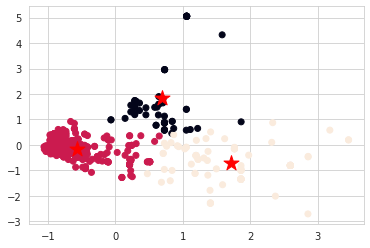

In [274]:
#クラスタリングの結果をmatplotlibを使って出力します。scatterを使ってプロットをしています。

plt.scatter(X_norm[:,0],X_norm[:,1], c=result.labels_)
plt.scatter(result.cluster_centers_[:,0],result.cluster_centers_[:,1],s=250, marker='*',c='red')
plt.show()

In [275]:
cls.labels_

array([1, 2, 0, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 0, 2, 1, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 2, 2, 1, 0,
       0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0,
       2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2,
       2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0,
       1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,

エルボー法

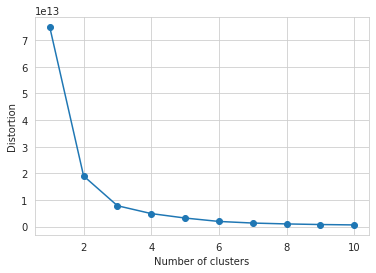

In [276]:
distortions = []

for i  in range(1,11):                # 1~10クラスタまで一気に計算 
    km = KMeans(n_clusters=i,
                init='k-means++',     # k-means++法によりクラスタ中心を選択
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)                         # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [277]:
#再度 k-meansを実行
km = KMeans(n_clusters=3,            # クラスターの個数
            init='k-means++',        # セントロイドの初期値をランダムに設定
            n_init=10,               # 異なるセントロイドの初期値を用いたk-meansあるゴリmズムの実行回数
            max_iter=300,            # k-meansアルゴリズムの内部の最大イテレーション回数
            tol=1e-04,               # 収束と判定するための相対的な許容誤差
            random_state=0)          # セントロイドの初期化に用いる乱数発生器の状態
y_km = km.fit_predict(X)

In [278]:
#こちらの'k-means++'の返り値の方を使う
km.labels_

array([1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 0, 2, 1, 2, 0, 2, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 2, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1,
       1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0,
       2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2,
       0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1,

シルエット図

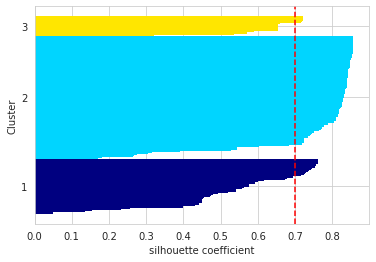

In [279]:
#シルエット図を書く
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(y_km)       # y_kmの要素の中で重複を無くす
n_clusters=cluster_labels.shape[0]     # 配列の長さを返す。つまりここでは n_clustersで指定した3となる

# シルエット係数を計算
silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')  # サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
y_ax_lower, y_ax_upper= 0,0
yticks = []

for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]      # cluster_labelsには 0,1,2が入っている（enumerateなのでiにも0,1,2が入ってる（たまたま））
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)              # サンプルの個数をクラスターごとに足し上げてy軸の最大値を決定
        color = cm.jet(float(i)/n_clusters)               # 色の値を作る
        plt.barh(range(y_ax_lower,y_ax_upper),            # 水平の棒グラフのを描画（底辺の範囲を指定）
                         c_silhouette_vals,               # 棒の幅（1サンプルを表す）
                         height=1.0,                      # 棒の高さ
                         edgecolor='none',                # 棒の端の色
                         color=color)                     # 棒の色
        yticks.append((y_ax_lower+y_ax_upper)/2)          # クラスタラベルの表示位置を追加
        y_ax_lower += len(c_silhouette_vals)              # 底辺の値に棒の幅を追加

silhouette_avg = np.mean(silhouette_vals)                 # シルエット係数の平均値
plt.axvline(silhouette_avg,color="red",linestyle="--")    # 係数の平均値に破線を引く 
plt.yticks(yticks,cluster_labels + 1)                     # クラスタレベルを表示
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

In [280]:
data['clust'] = km.labels_
data['clust'] = data['clust'].astype('category')
data[data['clust']== 2] 

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg_group,displacement_group,weight_group,acceleration_group,horsepower_group,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,M_sm,M_so,M_dm,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,weight_log,acceleration_log,clust
1,3,17.674521,8,350,150,4456,13.514535,72,1,dodge rampage,0,1,3,1,0,0.454933,43.750000,0.003033,0.001795,2800,35648,0.428571,52500,1200,18.750000,1559600,72,-576,-8,-25200,0,dodge,dodge rampage-1,dodge rampage-dodge,dodge rampage-72,dodge rampage-8,dodge rampage-150,4,8.402007,2.603766,2
24,56,22.503044,6,400,85,3193,17.189958,71,1,honda civic 1300,1,1,2,4,0,0.457609,66.666667,0.005384,0.001879,2400,19158,0.212500,34000,510,14.166667,1277200,71,-426,-6,-28400,0,honda,honda civic 1300-1,honda civic 1300-honda,honda civic 1300-71,honda civic 1300-6,honda civic 1300-85,4,8.068716,2.844325,2
29,63,22.050897,6,400,97,3193,15.232924,71,1,dodge monaco brougham,1,1,2,2,0,0.462760,66.666667,0.004771,0.001879,2400,19158,0.242500,38800,582,16.166667,1277200,71,-426,-6,-28400,0,dodge,dodge monaco brougham-1,dodge monaco brougham-dodge,dodge monaco brougham-71,dodge monaco brougham-6,dodge monaco brougham-97,4,8.068716,2.723459,2
46,94,17.201536,6,400,85,4154,17.018185,73,1,dodge monaco brougham,0,1,3,4,0,0.348230,66.666667,0.004097,0.001444,2400,24924,0.212500,34000,510,14.166667,1661600,73,-438,-6,-29200,0,dodge,dodge monaco brougham-1,dodge monaco brougham-dodge,dodge monaco brougham-73,dodge monaco brougham-6,dodge monaco brougham-85,8,8.331827,2.834282,2
63,123,22.827026,6,400,95,3193,13.225504,71,1,honda civic 1300,1,1,2,1,0,0.393493,66.666667,0.004142,0.001879,2400,19158,0.237500,38000,570,15.833333,1277200,71,-426,-6,-28400,0,honda,honda civic 1300-1,honda civic 1300-honda,honda civic 1300-71,honda civic 1300-6,honda civic 1300-95,4,8.068716,2.582147,2
88,168,23.167282,6,400,85,3193,17.219305,71,1,honda civic 1300,1,1,2,4,0,0.458391,66.666667,0.005393,0.001879,2400,19158,0.212500,34000,510,14.166667,1277200,71,-426,-6,-28400,0,honda,honda civic 1300-1,honda civic 1300-honda,honda civic 1300-71,honda civic 1300-6,honda civic 1300-85,4,8.068716,2.846031,2
93,177,22.421761,6,400,85,3193,17.167448,73,1,dodge monaco brougham,1,1,2,4,0,0.457010,66.666667,0.005377,0.001879,2400,19158,0.212500,34000,510,14.166667,1277200,73,-438,-6,-29200,0,dodge,dodge monaco brougham-1,dodge monaco brougham-dodge,dodge monaco brougham-73,dodge monaco brougham-6,dodge monaco brougham-85,6,8.068716,2.843015,2
95,182,17.443341,8,350,150,4456,13.508559,72,1,dodge rampage,0,1,3,1,0,0.454732,43.750000,0.003032,0.001795,2800,35648,0.428571,52500,1200,18.750000,1559600,72,-576,-8,-25200,0,dodge,dodge rampage-1,dodge rampage-dodge,dodge rampage-72,dodge rampage-8,dodge rampage-150,4,8.402007,2.603323,2
97,184,17.188052,8,318,150,3897,13.319598,75,1,capri ii,0,1,2,1,0,0.512687,39.750000,0.003418,0.002053,2544,31176,0.471698,47700,1200,18.750000,1239246,75,-600,-8,-23850,0,capri,capri ii-1,capri ii-capri,capri ii-75,capri ii-8,capri ii-150,4,8.267962,2.589236,2
105,199,17.020550,8,429,220,2720,9.719184,70,1,datsun 710,0,1,1,0,1,0.786110,53.625000,0.003573,0.002941,3432,21760,0.512821,94380,1760,27.500000,1166880,70,-560,-8,-30030,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,4,7.908387,2.274102,2


In [281]:
data['clust']

0      1
1      2
2      0
3      0
4      0
      ..
495    1
496    1
497    0
498    1
499    1
Name: clust, Length: 500, dtype: category
Categories (3, int64): [0, 1, 2]

# 4.トレーニングデータを学習/ H2oのAutoMLを使用

ライブラリのインポート

In [70]:
!pip install h2o

     |████████████████████████████████| 164.6MB 70kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=a61d4dc9d72565e6b279a9f0013be33f82c4805e3012255a297374db6e278f28
  Stored in directory: /root/.cache/pip/wheels/42/bd/ea/218fd15724eddf6fa7fc8fab802b6fa592e623d87199679721
Successfully built h2o


In [71]:
import h2o
from h2o.automl import H2OAutoML

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [72]:
# 初期化
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpozieh8a2
  JVM stdout: /tmp/tmpozieh8a2/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpozieh8a2/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_jedb4x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


説明変数の選定

In [73]:
#予測精度に貢献しないものをここで取捨選択しています。

target_col = 'mpg'

exclude_cols = ['id',
 'mpg',
 'mpg_group',
 'displacement_group',
 'weight_group',
 'acceleration_group',
 'horsepower_group',
 'ha_w',
 'd_c',
 'aw',
 'cw',
 'h_d',
 'hc',
 'dw',
 'mo',
 'M_sm',
 'M_so',
 'M_dm',
 'diesel_flag',
 'maker',
 'name-origin',
 'maker-origin',
 'name-year',
 'name-cylinders',
 'name-horsepower',
 'weight_log',
 'acceleration_log',
 'clust'
 ]

feature_cols = [colnames for colnames in data.columns if colnames not in exclude_cols]
feature_cols

['cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model year',
 'origin',
 'car name',
 'c_w',
 'dc',
 'hd',
 'h_c',
 'cylinders_c']

In [74]:
X_train = data[feature_cols]
y_train = data[target_col]
X_train_f, X_valid_f, y_train_f, y_valid_f = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1)

train = pd.merge(X_train_f, y_train_f, left_index=True, right_index=True)
valid = pd.merge(X_valid_f, y_valid_f, left_index=True, right_index=True)

h2o_train = h2o.H2OFrame(train) # H2Oに読み込ませるためにデータ型をH2OFrame型に変換
h2o_valid = h2o.H2OFrame(valid) # H2Oに読み込ませるためにデータ型をH2OFrame型に変換
print(h2o_train.shape)
print(h2o_valid.shape)

#h2o_train[target_col] = h2o_train[target_col].asfactor() # 分類問題を解くために目的変数を"int"→"enum"型に変更
#h2o_valid[target_col] = h2o_valid[target_col].asfactor() # 分類問題を解くために目的変数を"int"→"enum"型に変更

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(350, 14)
(150, 14)


In [78]:
# ハイパーパラメータを少しずつ調節して何度も学習しました。

aml = H2OAutoML(max_models = 16,nfolds=8, seed = 1234,)
aml.train(x=feature_cols, y=target_col,
          training_frame=h2o_train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [79]:
#leaderboard_frame: リーダーボード取得時に使用するデータを指定。学習データではなく、未知データに対して最も精度が高いモデルを取得したい場合こちらを指定
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20201213_050112,8.81565,2.96912,8.81565,1.97077,0.0998558
StackedEnsemble_AllModels_AutoML_20201213_050112,8.82487,2.97067,8.82487,1.96332,0.0997453
XGBoost_3_AutoML_20201213_050112,10.0379,3.16826,10.0379,2.06343,0.106502
DeepLearning_grid__1_AutoML_20201213_050112_model_1,10.1664,3.18848,10.1664,2.17583,0.109146
DRF_1_AutoML_20201213_050112,10.3432,3.21608,10.3432,1.99856,0.104705
XRT_1_AutoML_20201213_050112,10.5815,3.25292,10.5815,2.09239,0.107096
XGBoost_grid__1_AutoML_20201213_050112_model_2,10.5995,3.25569,10.5995,2.14544,0.107672
XGBoost_grid__1_AutoML_20201213_050112_model_1,10.8057,3.2872,10.8057,2.16337,0.109253
GBM_1_AutoML_20201213_050112,11.1767,3.34315,11.1767,1.96947,0.108259
XGBoost_1_AutoML_20201213_050112,11.2421,3.35292,11.2421,2.16855,0.11303


In [80]:
aml.leader.model_performance(h2o_valid).auc


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 9.613980306256321
RMSE: 3.1006419184188814
MAE: 1.8349916273048859
RMSLE: 0.1137390490530416
R^2: 0.8278298667012112
Mean Residual Deviance: 9.613980306256321
Null degrees of freedom: 149
Residual degrees of freedom: 144
Null deviance: 8382.87767737007
Residual deviance: 1442.0970459384482
AIC: 779.1643081152047


<bound method MetricsBase.auc of >

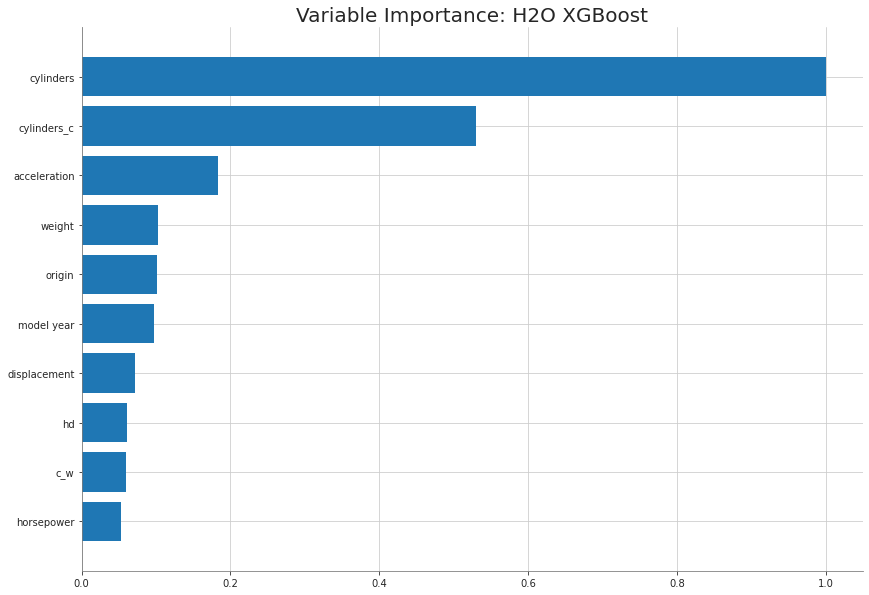

In [81]:
# 特徴量の重要度が知りたいので、StackedEnsemble以外のモデルを選びvariable importanceを取得します
leaderboard_df = aml.leaderboard.as_data_frame()
leaderboard_df = leaderboard_df[~leaderboard_df['model_id'].str.contains('StackedEnsemble')].reset_index()
model_id = leaderboard_df.at[0, 'model_id']
model = h2o.get_model(model_id)
model.varimp_plot()

# 5.テストデータを前処理

In [82]:
test_data = pd.read_csv('/content/drive/My Drive/自動車の走行距離予測コンペ/test.csv',)
test_data.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,1,4,98,67,2000,15.049795,81,1,peugeot 504
1,2,4,97,90,2720,15.339172,79,1,dodge aspen
2,5,4,90,75,2807,17.821599,77,1,dodge monaco brougham
3,6,4,140,110,2807,13.780354,82,2,buick century limited
4,8,4,121,85,3070,13.688921,73,2,saab 99le


In [83]:
#horsepowerの?を探します。
tyu = test_data[test_data['car name'] == 'renault lecar deluxe' ] 
tye = test_data[test_data['car name'] == 'renault lecar deluxe' ] 

tyu

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
30,54,4,85,74,1835,17.519205,80,2,renault lecar deluxe
111,235,4,85,74,1875,17.453700,80,2,renault lecar deluxe
249,489,4,90,120,2125,17.894257,77,3,renault lecar deluxe
340,676,4,90,120,4165,15.653980,77,3,renault lecar deluxe
407,814,4,85,?,1755,17.537356,80,1,renault lecar deluxe
429,863,4,85,110,1875,17.451905,81,1,renault lecar deluxe


In [84]:
#?を埋めていきます。

#?
test_data.loc[test_data['id']==206, 'horsepower'] = 69
##ポンティアックアストロ
test_data.loc[test_data['id']==358, 'horsepower'] = 70
#vw rabbit
test_data.loc[test_data['id']==780, 'horsepower'] = 72
test_data.loc[test_data['id']==875, 'horsepower'] = 72
test_data.loc[test_data['id']==765, 'horsepower'] = 71
#renault lecar deluxe
test_data.loc[test_data['id']==814, 'horsepower'] = 74

In [85]:
# horsepowerをint型に変換します。
test_data['horsepower'] = test_data['horsepower'].astype('int64')

以下、トレーニングデータと同様の処理

In [86]:
#馬力*加速度/重さ

ha_w = (test_data['horsepower'] * test_data['acceleration']) / test_data['weight']
#効果あり　#排気量*シリンダー
d_c = test_data['displacement'] / test_data['cylinders']
dc = test_data['displacement'] * test_data['cylinders'] #これ行ってみようか
#加速×重さ これはちがう
aw = test_data['acceleration'] / test_data['weight']
#シリンダー/ウェイト 効果あり
c_w = test_data['cylinders'] / test_data['weight']
cw = test_data['cylinders'] * test_data['weight']


#その他 効果は微妙
h_d = test_data['horsepower']/test_data['displacement']
hd = test_data['horsepower']*test_data['displacement']

#馬力とシリンダー
hc = test_data['horsepower'] * test_data['cylinders']
h_c= test_data['horsepower'] / test_data['cylinders'] #これいってみようか



test_data['ha_w'], test_data['d_c'], test_data['aw'], test_data['c_w'], test_data['dc'], test_data['cw'], test_data['h_d'],test_data['hd'], test_data['hc'], test_data['h_c'] = ha_w, d_c, aw, c_w, dc, cw, h_d, hd, hc, h_c


In [87]:
dw = data['displacement'] * test_data['weight']
mo = test_data['model year'] * test_data['origin']

test_data['dw'], test_data['mo'] = dw, mo

In [88]:
"""一見要注意の社名
'datsun 200-sx', 'datsun 200sx',　作られた年によって違う
'buick century',
       'buick century limited',　一緒にしていいかも
'datsun 210', 'datsun 210 mpg'　これも

'datsun pl510'　'datsun 510 (sw)'　

'ford gran torino', 'ford gran torino (sw)'
'toyota corolla', 'toyota mark ii','toyouta corona mark ii (sw)'
'volkswagen rabbit custom diesel',, 'vw rabbit custom'],
'vokswagen rabbit''vw rabbit
datsun 1200, hi 1200? →　別物"""

test_data = test_data.replace(
'buick century','buick century limited').replace(
'datsun 210','datsun 210 mpg').replace(
'ford gran torino', 'ford gran torino (sw)').replace(
'vw rabbit','vokswagen rabbit').replace('datsun 200-sx','datsun 200sx')

test_data['car name'].unique()

#.replace('datsun pl510','datsun 510 (sw)').replace(
#'toyota corolla', 'toyota mark ii').replace('toyota mark ii','toyouta corona mark ii (sw)').replace('volkswagen rabbit custom diesel','vw rabbit custom').replace('vw rabbit custom','vokswagen rabbit')



array(['peugeot 504', 'dodge aspen', 'dodge monaco brougham',
       'buick century limited', 'saab 99le', 'ford pinto',
       'peugeot 505s turbo diesel', 'opel 1900', 'ford futura',
       'datsun 810 maxima', 'amc gremlin', 'toyota corona liftback',
       'plymouth reliant', 'vw rabbit custom', 'audi 5000s (diesel)',
       'dodge rampage', 'datsun 210 mpg', 'ford fairmont (man)',
       'volkswagen dasher', 'honda civic 1300',
       'oldsmobile delta 88 royale', 'opel manta', 'ford escort 4w',
       'renault lecar deluxe', 'chevrolet vega', 'hi 1200d',
       'chevrolet nova', 'amc pacer d/l', 'datsun pl510',
       'ford mustang ii 2+2', 'chevrolet woody', 'vokswagen rabbit',
       'datsun 200sx', 'amc concord d/l', 'datsun 710',
       'oldsmobile cutlass ciera (diesel)', 'chevrolet caprice classic',
       'pontiac j2000 se hatchback', 'ford f108', 'toyota corolla',
       'buick regal sport coupe (turbo)', 'amc hornet',
       'mercury zephyr 6', 'plymouth volare premier v

In [89]:
#ディーゼルフラグを立てます
diesel_flag = []
for i in test_data['car name']:
  if i in 'diesel':
    diesel_flag.append(1)
  else:
    diesel_flag.append(0)    

test_data['diesel_flag'] = diesel_flag
#カテゴリー変数化
test_data['diesel_flag'] = test_data['diesel_flag'].astype('category')

In [90]:
df_spr = test_data['car name'].str.split(' ', expand=True)
test_data['maker'] = df_spr[0]
#メーカー名統一用　
test_data = test_data.replace('vw' , 'volkswagen').replace('vokswagen','volkswagen').replace('toyouta','toyota')
test_data['maker'].unique()

array(['peugeot', 'dodge', 'buick', 'saab', 'ford', 'opel', 'datsun',
       'amc', 'toyota', 'plymouth', 'volkswagen', 'audi', 'honda',
       'oldsmobile', 'renault', 'chevrolet', 'hi', 'pontiac', 'mercury',
       'fiat', 'triumph', 'volvo', 'capri', 'chevy'], dtype=object)

In [91]:
#かけ合わせフラグをたくさん作る
test_data['name-origin'] = test_data['car name'] + '-' + test_data['origin'].astype(str)
test_data['maker-origin'] = test_data['car name'] + '-' + test_data['maker']
test_data['name-year'] = test_data['car name'] + '-' + test_data['model year'].astype(str)
test_data['name-cylinders'] = test_data['car name'] + '-' + test_data['cylinders'].astype(str)
test_data['name-horsepower'] = test_data['car name'] + '-' + test_data['horsepower'].astype(str)
#保留、考え方はあり
#data['name-origin'] = data['maker'] + '-' + data['cylinder'].astype(str) + '-' + data['displacement']

In [92]:
#オリジンはカテゴリーデータ
test_data['origin'] = test_data['origin'].astype('category')
#シリンダーもカテゴリーで実験
test_data['cylinders_c'] = test_data['cylinders'].astype('category')


category_col = ['cylinders', 'origin'] 
test_data = chenge_into_category(test_data, category_col)

In [93]:
test_data['displacement_log'] =test_data['displacement'].apply(np.log)

In [94]:
test_data['displacement_log']

0      4.584967
1      4.574711
2      4.499810
3      4.941642
4      4.795791
         ...   
495    5.416100
496    4.941642
497    5.762051
498    4.499810
499    4.499810
Name: displacement_log, Length: 500, dtype: float64

In [ ]:
test_data.to_csv('テスト2モデル実験用1107.csv', index=False)

In [95]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                500 non-null    int64   
 1   cylinders         500 non-null    category
 2   displacement      500 non-null    int64   
 3   horsepower        500 non-null    int64   
 4   weight            500 non-null    int64   
 5   acceleration      500 non-null    float64 
 6   model year        500 non-null    int64   
 7   origin            500 non-null    category
 8   car name          500 non-null    object  
 9   ha_w              500 non-null    float64 
 10  d_c               500 non-null    float64 
 11  aw                500 non-null    float64 
 12  c_w               500 non-null    float64 
 13  dc                500 non-null    int64   
 14  cw                500 non-null    int64   
 15  h_d               500 non-null    float64 
 16  hd                500 non-

In [305]:
test_data

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,displacement_log
0,1,4,98,67,2000,15.049795,81,1,peugeot 504,0.504168,24.50,0.007525,0.002000,392,8000,0.683673,6566,268,16.75,280000,81,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-67,4,4.584967
1,2,4,97,90,2720,15.339172,79,1,dodge aspen,0.507546,24.25,0.005639,0.001471,388,10880,0.927835,8730,360,22.50,952000,79,0,dodge,dodge aspen-1,dodge aspen-dodge,dodge aspen-79,dodge aspen-4,dodge aspen-90,4,4.574711
2,5,4,90,75,2807,17.821599,77,1,dodge monaco brougham,0.476174,22.50,0.006349,0.001425,360,11228,0.833333,6750,300,18.75,847714,77,0,dodge,dodge monaco brougham-1,dodge monaco brougham-dodge,dodge monaco brougham-77,dodge monaco brougham-4,dodge monaco brougham-75,4,4.499810
3,6,4,140,110,2807,13.780354,82,2,buick century limited,0.540021,35.00,0.004909,0.001425,560,11228,0.785714,15400,440,27.50,1122800,164,0,buick,buick century limited-2,buick century limited-buick,buick century limited-82,buick century limited-4,buick century limited-110,4,4.941642
4,8,4,121,85,3070,13.688921,73,2,saab 99le,0.379009,30.25,0.004459,0.001303,484,12280,0.702479,10285,340,21.25,1317030,146,0,saab,saab 99le-2,saab 99le-saab,saab 99le-73,saab 99le-4,saab 99le-85,4,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,992,4,225,105,3870,15.376311,76,1,chevrolet nova,0.417187,56.25,0.003973,0.001034,900,15480,0.466667,23625,420,26.25,541800,76,0,chevrolet,chevrolet nova-1,chevrolet nova-chevrolet,chevrolet nova-76,chevrolet nova-4,chevrolet nova-105,4,5.416100
496,993,4,140,112,2720,13.616843,82,1,buick century limited,0.560694,35.00,0.005006,0.001471,560,10880,0.800000,15680,448,28.00,263840,82,0,buick,buick century limited-1,buick century limited-buick,buick century limited-82,buick century limited-4,buick century limited-112,4,4.941642
497,996,8,318,110,2774,13.272636,75,1,ford ltd,0.526312,39.75,0.004785,0.002884,2544,22192,0.345912,34980,880,13.75,837748,75,0,ford,ford ltd-1,ford ltd-ford,ford ltd-75,ford ltd-8,ford ltd-110,8,5.762051
498,998,4,90,75,2807,17.792560,77,1,dodge monaco brougham,0.475398,22.50,0.006339,0.001425,360,11228,0.833333,6750,300,18.75,272279,77,0,dodge,dodge monaco brougham-1,dodge monaco brougham-dodge,dodge monaco brougham-77,dodge monaco brougham-4,dodge monaco brougham-75,4,4.499810


# 6.テストデータを予測（H2o）

In [98]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                500 non-null    int64   
 1   cylinders         500 non-null    category
 2   displacement      500 non-null    int64   
 3   horsepower        500 non-null    int64   
 4   weight            500 non-null    int64   
 5   acceleration      500 non-null    float64 
 6   model year        500 non-null    int64   
 7   origin            500 non-null    category
 8   car name          500 non-null    object  
 9   ha_w              500 non-null    float64 
 10  d_c               500 non-null    float64 
 11  aw                500 non-null    float64 
 12  c_w               500 non-null    float64 
 13  dc                500 non-null    int64   
 14  cw                500 non-null    int64   
 15  h_d               500 non-null    float64 
 16  hd                500 non-

In [102]:
preds = aml.predict(h2o.H2OFrame(test_data.drop(['id',
 'ha_w',
 'd_c',
 'aw',
 'cw',
 'h_d',
 'hc',
 'dw',
 'mo',
 'diesel_flag',
 'maker',
 'name-origin',
 'maker-origin',
 'name-year',
 'name-cylinders',
 'name-horsepower',
], axis=1)))

preds.head(20)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


predict
36.7127
27.0205
27.0315
33.132
23.9584
41.5785
26.6731
26.6788
30.7713
18.384


In [103]:
#predsがH2oフレーム型なのでリストに変換してテストデータに結合します
poi = preds.as_data_frame()
poi_2 = poi['predict'].tolist()
test_data['0.0'] = poi_2 

In [104]:
test_data.rename(columns={'id':'1'}, inplace=True)
submit_data = test_data[['1', '0.0']]

In [105]:
submit_data.head()

,1,0.0
0,1,36.712730
1,2,27.020491
2,5,27.031503
3,6,33.132032
4,8,23.958389


In [106]:
submit_data.columns = [0,1]

In [107]:
submit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       500 non-null    int64  
 1   1       500 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.9 KB


In [108]:
submit_data

,0,1
0,1,36.712730
1,2,27.020491
2,5,27.031503
3,6,33.132032
4,8,23.958389
...,...,...
495,992,29.503839
496,993,34.380117
497,996,18.981262
498,998,27.034757


In [315]:
# 提出用csvファイルを書き出します。

submit_data.to_csv('自動車予測_22.csv', index=False)

# LGBM（不採用）

In [109]:
#オリジンゲットダミー用

origin_dummie = pd.get_dummies(data['origin'], drop_first=True,prefix='origin')
data = pd.concat([data.drop(['origin'],axis=1),origin_dummie], axis=1)


In [110]:
kaiki_data = data

In [135]:
kaiki_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  500 non-null    int64   
 1   mpg                 500 non-null    float64 
 2   cylinders           500 non-null    int64   
 3   displacement        500 non-null    int64   
 4   horsepower          500 non-null    int64   
 5   weight              500 non-null    int64   
 6   acceleration        500 non-null    float64 
 7   model year          500 non-null    int64   
 8   car name            500 non-null    category
 9   mpg_group           500 non-null    category
 10  displacement_group  500 non-null    category
 11  weight_group        500 non-null    category
 12  acceleration_group  500 non-null    category
 13  horsepower_group    500 non-null    category
 14  ha_w                500 non-null    float64 
 15  d_c                 500 non-null    floa

In [111]:
#データ数が多いときは作動させない
df_house_corr = kaiki_data.corr()

print(df_house_corr.shape)
# (37, 37)
df_house_corr

(27, 27)


,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,M_sm,M_so,M_dm,weight_log,acceleration_log,origin_2,origin_3
id,1.000000,-0.032431,0.029843,0.041551,0.077420,0.049271,-0.059960,-0.027644,0.022853,0.039602,-0.069198,-0.002080,0.041969,0.044826,0.011399,0.063293,0.065044,0.055389,0.056400,-0.040600,-0.028181,0.028423,-0.043195,0.047062,-0.055897,0.008771,-0.045176
mpg,-0.032431,1.000000,-0.739658,-0.605029,-0.477082,-0.261404,0.344398,0.422820,-0.080298,-0.241254,0.429196,-0.464014,-0.687920,-0.637131,0.279171,-0.601754,-0.658310,0.190704,-0.556717,0.480094,0.698775,-0.035139,0.585659,-0.289757,0.362831,0.308269,0.345858
cylinders,0.029843,-0.739658,1.000000,0.726896,0.548928,0.289985,-0.371380,-0.295352,0.101608,0.187620,-0.449292,0.707206,0.890717,0.823954,-0.401055,0.755340,0.862079,-0.378516,0.672845,-0.333400,-0.986432,-0.221297,-0.722007,0.299213,-0.399985,-0.229142,-0.235964
displacement,0.041551,-0.605029,0.726896,1.000000,0.473558,0.349656,-0.314126,-0.375943,0.007196,0.789561,-0.475838,0.420101,0.944284,0.668147,-0.687341,0.875331,0.670526,-0.199314,0.905866,-0.342022,-0.680833,-0.053127,-0.994672,0.361044,-0.356142,-0.142799,-0.273705
horsepower,0.077420,-0.477082,0.548928,0.473558,1.000000,0.212301,-0.410613,-0.238453,0.607119,0.196749,-0.402355,0.357272,0.561879,0.483889,0.188005,0.787549,0.875302,0.537859,0.446935,-0.292003,-0.523138,0.008007,-0.467538,0.214570,-0.440655,0.008060,-0.285434
weight,0.049271,-0.261404,0.289985,0.349656,0.212301,1.000000,0.023480,-0.230062,-0.484550,0.271794,-0.797839,-0.442712,0.331666,0.752745,-0.233221,0.312361,0.270273,-0.044460,0.666182,-0.135521,-0.255179,-0.026119,-0.340185,0.991379,0.021885,0.129953,-0.168232
acceleration,-0.059960,0.344398,-0.371380,-0.314126,-0.410613,0.023480,1.000000,0.167045,0.060229,-0.097462,0.518101,-0.366380,-0.395698,-0.226729,0.047369,-0.433949,-0.451440,-0.083439,-0.219134,0.085347,0.347980,0.139056,0.299052,0.014233,0.992457,0.188706,0.003308
model year,-0.027644,0.422820,-0.295352,-0.375943,-0.238453,-0.230062,0.167045,1.000000,0.030365,-0.231819,0.276630,-0.101593,-0.381945,-0.338292,0.139406,-0.355250,-0.297359,0.038843,-0.386815,0.207893,0.141654,0.035002,0.291827,-0.226490,0.204001,0.018787,0.117610
ha_w,0.022853,-0.080298,0.101608,0.007196,0.607119,-0.484550,0.060229,0.030365,1.000000,-0.072620,0.435018,0.447007,0.059682,-0.200110,0.446642,0.263212,0.389694,0.570289,-0.180830,-0.140928,-0.116427,0.109889,-0.018325,-0.489399,0.040287,0.017402,-0.154969
d_c,0.039602,-0.241254,0.187620,0.789561,0.196749,0.271794,-0.097462,-0.231819,-0.072620,1.000000,-0.304129,-0.013556,0.548058,0.255671,-0.644936,0.570120,0.207211,0.037528,0.709714,-0.201013,-0.147084,0.105375,-0.797081,0.285931,-0.126434,-0.003029,-0.191937


In [112]:
import matplotlib.pyplot as plt # グラフ描画用
import seaborn as sns; sns.set() # グラフ描画用
import numpy as np
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
import lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
from sklearn.metrics import mean_squared_error # モデル評価用(平均二乗誤差)
from sklearn.metrics import r2_score # モデル評価用(決定係数)

# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [141]:
#https://mathmatical22.xyz/2020/04/09/%e3%80%90%e5%88%9d%e5%ad%a6%e8%80%85%e5%90%91%e3%81%91%e3%80%91lightgbm-%e5%9f%ba%e6%9c%ac%e7%9a%84%e3%81%aa%e4%bd%bf%e3%81%84%e6%96%b9-%e5%9b%9e%e5%b8%b0%e5%88%86%e6%9e%90%e7%b7%a8%e3%80%90python/
# 説明変数,目的変数
X = kaiki_data.drop(['id', 'mpg','mpg_group', 'maker','car name', 'name-origin',	'maker-origin',
                                         'name-year',	'name-cylinders',
                                         'name-horsepower' ],axis=1).values # 説明変数(loss以外の特徴量)
y = kaiki_data['mpg'].values # 目的変数(loss)

# トレーニングデータ,テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=2)


In [142]:
# モデルの学習 LightGBM (scikit-learn API)
model_kaiki = lgb.LGBMRegressor() # モデルのインスタンスの作成
model_kaiki.fit(X_train, y_train) # モデルの学習

# テストデータの予測
y_pred = model_kaiki.predict(X_test)

Text(0.5, 1.0, 'y vs y_pred')

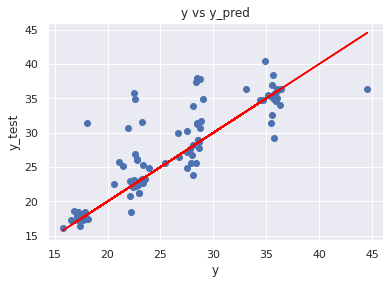

In [143]:
# 散布図を描画(真値 vs 予測値)
plt.plot(y_test, y_test, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
plt.scatter(y_test, y_pred) # 散布図のプロット
plt.xlabel('y') # x軸ラベル
plt.ylabel('y_test') # y軸ラベル
plt.title('y vs y_pred') # グラフタイトル

In [144]:
# モデル評価
# rmse : 平均二乗誤差の平方根
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) # RSME = √MSEの算出
print('RMSE :',rmse)

# r2 : 決定係数
r2 = r2_score(y_test,y_pred)
print('R2 :',r2)

RMSE : 3.6988696447402902
R2 : 0.672419972190076


# テストデータをEDA

In [115]:
#test_dataはcar nameは81種類
t= test_data['car name'].unique()
print(len(t))

77


In [116]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   1                 500 non-null    int64   
 1   cylinders         500 non-null    category
 2   displacement      500 non-null    int64   
 3   horsepower        500 non-null    int64   
 4   weight            500 non-null    int64   
 5   acceleration      500 non-null    float64 
 6   model year        500 non-null    int64   
 7   origin            500 non-null    category
 8   car name          500 non-null    object  
 9   ha_w              500 non-null    float64 
 10  d_c               500 non-null    float64 
 11  aw                500 non-null    float64 
 12  c_w               500 non-null    float64 
 13  dc                500 non-null    int64   
 14  cw                500 non-null    int64   
 15  h_d               500 non-null    float64 
 16  hd                500 non-

In [118]:
peugeot = data[data['car name'] == 'peugeot 504']

In [119]:
peugeot

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,mpg_group,displacement_group,weight_group,acceleration_group,horsepower_group,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,M_sm,M_so,M_dm,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,weight_log,acceleration_log,origin_2,origin_3
36,80,35.617170,4,98,90,2000,15.112812,81,peugeot 504,3,0,0,2,0,0.680077,24.50,0.007556,0.002000,392,8000,0.918367,8820,360,22.50,196000,81,-324,-4,-7938,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-90,4,7.600902,2.715543,0,0
39,84,28.536821,4,98,90,3353,15.438983,80,peugeot 504,2,0,2,2,0,0.414408,24.50,0.004605,0.001193,392,13412,0.918367,8820,360,22.50,328594,80,-320,-4,-7840,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-80,peugeot 504-4,peugeot 504-90,4,8.117611,2.736896,0,0
80,149,35.674300,4,105,70,2000,15.056761,81,peugeot 504,3,0,0,2,0,0.526987,26.25,0.007528,0.002000,420,8000,0.666667,7350,280,17.50,210000,81,-324,-4,-8505,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-70,4,7.600902,2.711827,0,0
85,163,36.183679,4,105,67,2000,15.089393,81,peugeot 504,3,0,0,2,0,0.505495,26.25,0.007545,0.002000,420,8000,0.638095,7035,268,16.75,210000,81,-324,-4,-8505,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-67,4,7.600902,2.713992,0,0
115,221,35.143613,4,105,67,2000,15.059367,81,peugeot 504,3,0,0,2,0,0.504489,26.25,0.007530,0.002000,420,8000,0.638095,7035,268,16.75,210000,81,-324,-4,-8505,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-67,4,7.600902,2.712000,0,0
138,276,28.466359,4,98,90,3353,15.329353,79,peugeot 504,2,0,2,2,0,0.411465,24.50,0.004572,0.001193,392,13412,0.918367,8820,360,22.50,328594,79,-316,-4,-7742,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-79,peugeot 504-4,peugeot 504-90,4,8.117611,2.729769,0,0
144,286,36.346837,4,105,67,2000,15.039677,81,peugeot 504,3,0,0,2,0,0.503829,26.25,0.007520,0.002000,420,8000,0.638095,7035,268,16.75,210000,81,-324,-4,-8505,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-67,4,7.600902,2.710692,0,0
162,327,35.565615,4,98,67,2000,15.001267,81,peugeot 504,3,0,0,2,0,0.502542,24.50,0.007501,0.002000,392,8000,0.683673,6566,268,16.75,196000,81,-324,-4,-7938,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-67,4,7.600902,2.708135,0,0
229,464,36.148124,4,105,70,2000,15.064963,81,peugeot 504,3,0,0,2,0,0.527274,26.25,0.007532,0.002000,420,8000,0.666667,7350,280,17.50,210000,81,-324,-4,-8505,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-70,4,7.600902,2.712372,0,0
241,498,35.976772,4,98,67,2000,15.060626,81,peugeot 504,3,0,0,2,0,0.504531,24.50,0.007530,0.002000,392,8000,0.683673,6566,268,16.75,196000,81,-324,-4,-7938,0,peugeot,peugeot 504-1,peugeot 504-peugeot,peugeot 504-81,peugeot 504-4,peugeot 504-67,4,7.600902,2.712084,0,0


In [120]:
test_name_dummies = pd.get_dummies(data['car name'])
test_name_dummies.columns

CategoricalIndex(['amc ambassador dpl', 'amc gremlin', 'amc hornet',
                  'amc matador', 'amc pacer d/l', 'amc spirit dl',
                  'audi 5000s (diesel)', 'buick century',
                  'buick century limited', 'buick lesabre custom',
                  'buick regal sport coupe (turbo)', 'buick skyhawk',
                  'capri ii', 'chevrolet caprice classic', 'chevrolet impala',
                  'chevrolet monza 2+2', 'chevrolet nova', 'chevrolet vega',
                  'chevrolet woody', 'datsun 1200', 'datsun 200-sx',
                  'datsun 200sx', 'datsun 210', 'datsun 210 mpg',
                  'datsun 510 (sw)', 'datsun 710', 'datsun 810 maxima',
                  'datsun pl510', 'dodge aries se', 'dodge aspen',
                  'dodge colt', 'dodge coronet custom', 'dodge magnum xe',
                  'dodge monaco brougham', 'dodge omni', 'dodge rampage',
                  'fiat 124 sport coupe', 'fiat 128', 'ford fairmont (man)',
             

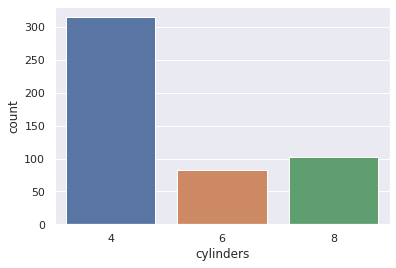

In [121]:
sns.countplot("cylinders",data=test_data)

In [122]:
sns.barplot(y="cylinders", x="car name", hue="cylinders", data=test_data)

TypeError: ignored

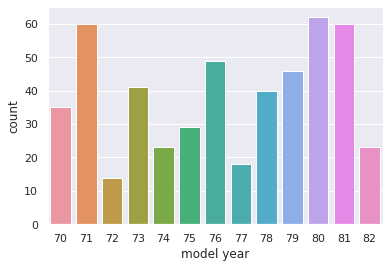

In [123]:
sns.countplot("model year",data=test_data)

Text(0, 0.5, 'car')

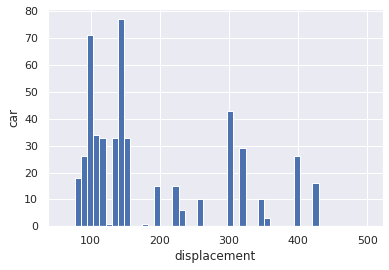

In [124]:
plt.hist(test_data['displacement'], bins=50, range=(60,500))
plt.xlabel("displacement")
plt.ylabel("car")

Text(0, 0.5, 'car')

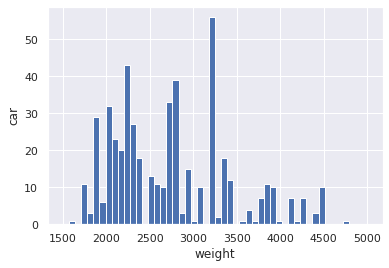

In [125]:
plt.hist(test_data['weight'], bins=50, range=(1500,5000))
plt.xlabel("weight")
plt.ylabel("car")

In [126]:
data[test_data['weight'] > 4000]

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,mpg_group,displacement_group,weight_group,acceleration_group,horsepower_group,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,M_sm,M_so,M_dm,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,weight_log,acceleration_log,origin_2,origin_3
16,33,28.361424,4,140,72,2200,19.282897,76,chevrolet vega,2,0,0,4,0,0.631077,35.000000,0.008765,0.001818,560,8800,0.514286,10080,288,18.000000,308000,76,-304,-4,-10640,0,chevrolet,chevrolet vega-1,chevrolet vega-chevrolet,chevrolet vega-76,chevrolet vega-4,chevrolet vega-72,4,7.696213,2.959219,0,0
22,47,28.301643,4,140,88,2300,15.163064,78,buick century,2,0,0,2,0,0.580152,35.000000,0.006593,0.001739,560,9200,0.628571,12320,352,22.000000,322000,234,-312,-12,-10920,0,buick,buick century-3,buick century-buick,buick century-78,buick century-4,buick century-88,4,7.740664,2.718862,0,1
27,59,36.317000,4,104,60,2123,14.864609,81,datsun 200sx,3,0,0,2,0,0.420102,26.000000,0.007002,0.001884,416,8492,0.576923,6240,240,15.000000,220792,243,-324,-12,-8424,0,datsun,datsun 200sx-3,datsun 200sx-datsun,datsun 200sx-81,datsun 200sx-4,datsun 200sx-60,4,7.660585,2.698983,0,1
38,83,27.634695,4,98,60,1760,19.935120,76,chevrolet woody,2,0,0,4,0,0.679606,24.500000,0.011327,0.002273,392,7040,0.612245,5880,240,15.000000,172480,76,-304,-4,-7448,0,chevrolet,chevrolet woody-1,chevrolet woody-chevrolet,chevrolet woody-76,chevrolet woody-4,chevrolet woody-60,4,7.473069,2.992483,0,0
75,139,28.790093,4,116,90,2670,15.449740,71,volkswagen dasher,2,0,1,2,0,0.520778,29.000000,0.005786,0.001498,464,10680,0.775862,10440,360,22.500000,309720,71,-284,-4,-8236,0,volkswagen,volkswagen dasher-1,volkswagen dasher-volkswagen,volkswagen dasher-71,volkswagen dasher-4,volkswagen dasher-90,4,7.889834,2.737592,0,0
88,168,23.167282,6,400,85,3193,17.219305,71,honda civic 1300,1,1,2,4,0,0.458391,66.666667,0.005393,0.001879,2400,19158,0.212500,34000,510,14.166667,1277200,71,-426,-6,-28400,0,honda,honda civic 1300-1,honda civic 1300-honda,honda civic 1300-71,honda civic 1300-6,honda civic 1300-85,6,8.068716,2.846031,0,0
92,176,23.144460,8,302,140,2210,13.295377,79,plymouth reliant,1,1,0,1,0,0.842241,37.750000,0.006016,0.003620,2416,17680,0.463576,42280,1120,17.500000,667420,79,-632,-8,-23858,0,plymouth,plymouth reliant-1,plymouth reliant-plymouth,plymouth reliant-79,plymouth reliant-8,plymouth reliant-140,8,7.700748,2.587416,0,0
98,185,26.896951,4,141,97,3233,15.356764,81,peugeot 505s turbo diesel,2,0,2,2,0,0.460750,35.250000,0.004750,0.001237,564,12932,0.687943,13677,388,24.250000,455853,81,-324,-4,-11421,0,peugeot,peugeot 505s turbo diesel-1,peugeot 505s turbo diesel-peugeot,peugeot 505s turbo diesel-81,peugeot 505s turbo diesel-4,peugeot 505s turbo diesel-97,4,8.081166,2.731556,0,0
99,189,27.805661,4,305,148,3233,15.601424,82,datsun 200-sx,2,1,2,2,0,0.714201,76.250000,0.004826,0.001237,1220,12932,0.485246,45140,592,37.000000,986065,164,-328,-8,-25010,0,datsun,datsun 200-sx-2,datsun 200-sx-datsun,datsun 200-sx-82,datsun 200-sx-4,datsun 200-sx-148,4,8.081166,2.747362,1,0
142,282,17.694637,8,302,220,2774,15.165367,76,triumph tr7 coupe,0,1,1,2,1,1.202733,37.750000,0.005467,0.002884,2416,22192,0.728477,66440,1760,27.500000,837748,76,-608,-8,-22952,0,triumph,triumph tr7 coupe-1,triumph tr7 coupe-triumph,triumph tr7 coupe-76,triumph tr7 coupe-8,triumph tr7 coupe-220,8,7.928046,2.719014,0,0


Text(0, 0.5, 'car')

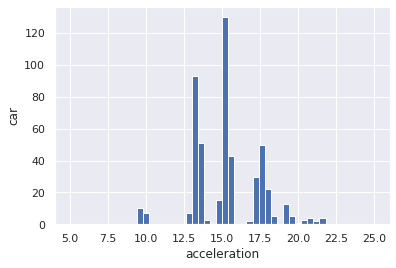

In [127]:
plt.hist(test_data['acceleration'], bins=50, range=(5,25))
plt.xlabel("acceleration")
plt.ylabel("car")

In [128]:
test_data[test_data['acceleration'] > 16]

,1,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,displacement_log,0.0
2,5,4,90,75,2807,17.821599,77,1,dodge monaco brougham,0.476174,22.500000,0.006349,0.001425,360,11228,0.833333,6750,300,18.750000,847714,77,0,dodge,dodge monaco brougham-1,dodge monaco brougham-dodge,dodge monaco brougham-77,dodge monaco brougham-4,dodge monaco brougham-75,4,4.499810,27.031503
5,10,4,85,110,1985,20.978972,80,2,ford pinto,1.162563,21.250000,0.010569,0.002015,340,7940,1.294118,9350,440,27.500000,277900,160,0,ford,ford pinto-2,ford pinto-ford,ford pinto-80,ford pinto-4,ford pinto-110,4,4.442651,41.578492
8,15,4,97,148,2234,17.788627,71,2,opel 1900,1.178477,24.250000,0.007963,0.001791,388,8936,1.525773,14356,592,37.000000,446800,142,0,opel,opel 1900-2,opel 1900-opel,opel 1900-71,opel 1900-4,opel 1900-148,4,4.574711,30.771328
9,17,6,318,110,1925,19.209154,75,1,ford futura,1.097666,53.000000,0.009979,0.003117,1908,11550,0.345912,34980,660,18.333333,200200,75,0,ford,ford futura-1,ford futura-ford,ford futura-75,ford futura-6,ford futura-110,6,5.762051,18.383962
14,27,6,318,110,3205,19.203514,75,1,vw rabbit custom,0.659091,53.000000,0.005992,0.001872,1908,19230,0.345912,34980,660,18.333333,381395,75,0,volkswagen,vw rabbit custom-1,vw rabbit custom-volkswagen,vw rabbit custom-75,vw rabbit custom-6,vw rabbit custom-110,6,5.762051,17.991748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,975,4,80,67,2755,17.674119,80,3,datsun 510 (sw),0.429824,20.000000,0.006415,0.001452,320,11020,0.837500,5360,268,16.750000,267235,240,0,datsun,datsun 510 (sw)-3,datsun 510 (sw)-datsun,datsun 510 (sw)-80,datsun 510 (sw)-4,datsun 510 (sw)-67,4,4.382027,35.063435
488,985,6,400,100,2295,17.012010,80,1,honda civic 1300,0.741264,66.666667,0.007413,0.002614,2400,13770,0.250000,40000,600,16.666667,206550,80,0,honda,honda civic 1300-1,honda civic 1300-honda,honda civic 1300-80,honda civic 1300-6,honda civic 1300-100,6,5.991465,25.250555
490,987,6,140,110,2815,18.075032,80,1,dodge aspen,0.706307,23.333333,0.006421,0.002131,840,16890,0.785714,15400,660,18.333333,563000,80,0,dodge,dodge aspen-1,dodge aspen-dodge,dodge aspen-80,dodge aspen-6,dodge aspen-110,6,4.941642,23.273661
498,998,4,90,75,2807,17.792560,77,1,dodge monaco brougham,0.475398,22.500000,0.006339,0.001425,360,11228,0.833333,6750,300,18.750000,272279,77,0,dodge,dodge monaco brougham-1,dodge monaco brougham-dodge,dodge monaco brougham-77,dodge monaco brougham-4,dodge monaco brougham-75,4,4.499810,27.034757


Text(0, 0.5, 'car')

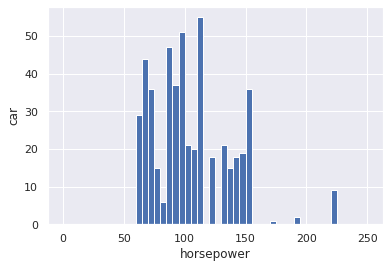

In [129]:
plt.hist(test_data['horsepower'], bins=50, range=(0,250))
plt.xlabel("horsepower")
plt.ylabel("car")

In [130]:
test_data[test_data['horsepower'] > 175]

,1,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,displacement_log,0.0
38,71,4,151,190,4274,13.353624,71,2,ford mustang ii 2+2,0.593633,37.750000,0.003124,0.000936,604,17096,1.258278,28690,760,47.500000,418852,142,0,ford,ford mustang ii 2+2-2,ford mustang ii 2+2-ford,ford mustang ii 2+2-71,ford mustang ii 2+2-4,ford mustang ii 2+2-190,4,5.017280,35.160644
50,101,8,429,220,2245,9.630367,70,1,datsun 710,0.943733,53.625000,0.004290,0.003563,3432,17960,0.512821,94380,1760,27.500000,338995,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.425729
146,299,8,429,220,2245,9.613474,70,1,datsun 710,0.942078,53.625000,0.004282,0.003563,3432,17960,0.512821,94380,1760,27.500000,300830,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.426878
225,443,8,429,220,2245,9.575782,70,1,datsun 710,0.938384,53.625000,0.004265,0.003563,3432,17960,0.512821,94380,1760,27.500000,713910,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.427986
228,452,8,429,220,2245,9.551462,70,1,datsun 710,0.936001,53.625000,0.004255,0.003563,3432,17960,0.512821,94380,1760,27.500000,217765,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.430038
277,538,8,429,220,2245,9.550639,70,1,datsun 710,0.935920,53.625000,0.004254,0.003563,3432,17960,0.512821,94380,1760,27.500000,518595,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.430108
348,691,8,429,220,2245,9.691107,70,1,ford galaxie 500,0.949685,53.625000,0.004317,0.003563,3432,17960,0.512821,94380,1760,27.500000,300830,70,0,ford,ford galaxie 500-1,ford galaxie 500-ford,ford galaxie 500-70,ford galaxie 500-8,ford galaxie 500-220,8,6.061457,17.758951
388,783,8,429,220,2720,9.879788,70,1,ford galaxie 500,0.799101,53.625000,0.003632,0.002941,3432,21760,0.512821,94380,1760,27.500000,410720,70,0,ford,ford galaxie 500-1,ford galaxie 500-ford,ford galaxie 500-70,ford galaxie 500-8,ford galaxie 500-220,8,6.061457,17.560914
433,873,8,429,220,2245,9.644335,70,1,ford galaxie 500,0.945102,53.625000,0.004296,0.003563,3432,17960,0.512821,94380,1760,27.500000,579210,70,0,ford,ford galaxie 500-1,ford galaxie 500-ford,ford galaxie 500-70,ford galaxie 500-8,ford galaxie 500-220,8,6.061457,17.758410
458,922,8,429,220,2720,9.855429,70,1,ford galaxie 500,0.797130,53.625000,0.003623,0.002941,3432,21760,0.512821,94380,1760,27.500000,410720,70,0,ford,ford galaxie 500-1,ford galaxie 500-ford,ford galaxie 500-70,ford galaxie 500-8,ford galaxie 500-220,8,6.061457,17.565497


In [131]:
test_data[test_data['acceleration'] < 12]

,1,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,displacement_log,0.0
32,60,8,429,82,2245,9.826745,70,1,hi 1200d,0.358928,53.625,0.004377,0.003563,3432,17960,0.191142,35178,656,10.25,677990,70,0,hi,hi 1200d-1,hi 1200d-hi,hi 1200d-70,hi 1200d-8,hi 1200d-82,8,6.061457,17.293543
50,101,8,429,220,2245,9.630367,70,1,datsun 710,0.943733,53.625,0.004290,0.003563,3432,17960,0.512821,94380,1760,27.50,338995,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.425729
80,170,8,429,82,2245,9.809975,70,1,ford galaxie 500,0.358315,53.625,0.004370,0.003563,3432,17960,0.191142,35178,656,10.25,235725,70,0,ford,ford galaxie 500-1,ford galaxie 500-ford,ford galaxie 500-70,ford galaxie 500-8,ford galaxie 500-82,8,6.061457,17.706846
89,188,8,429,122,2245,9.581096,70,1,datsun 710,0.520665,53.625,0.004268,0.003563,3432,17960,0.284382,52338,976,15.25,199805,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-122,8,6.061457,17.485021
146,299,8,429,220,2245,9.613474,70,1,datsun 710,0.942078,53.625,0.004282,0.003563,3432,17960,0.512821,94380,1760,27.50,300830,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.426878
176,350,8,429,150,2720,9.851121,70,1,ford galaxie 500,0.543260,53.625,0.003622,0.002941,3432,21760,0.349650,64350,1200,18.75,864960,70,0,ford,ford galaxie 500-1,ford galaxie 500-ford,ford galaxie 500-70,ford galaxie 500-8,ford galaxie 500-150,8,6.061457,17.916224
210,413,8,429,82,2720,9.971925,70,1,hi 1200d,0.300624,53.625,0.003666,0.002941,3432,21760,0.191142,35178,656,10.25,263840,70,0,hi,hi 1200d-1,hi 1200d-hi,hi 1200d-70,hi 1200d-8,hi 1200d-82,8,6.061457,17.309153
225,443,8,429,220,2245,9.575782,70,1,datsun 710,0.938384,53.625,0.004265,0.003563,3432,17960,0.512821,94380,1760,27.50,713910,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.427986
228,452,8,429,220,2245,9.551462,70,1,datsun 710,0.936001,53.625,0.004255,0.003563,3432,17960,0.512821,94380,1760,27.50,217765,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-220,8,6.061457,17.430038
264,516,8,429,122,2245,9.597198,70,1,datsun 710,0.521540,53.625,0.004275,0.003563,3432,17960,0.284382,52338,976,15.25,202050,70,0,datsun,datsun 710-1,datsun 710-datsun,datsun 710-70,datsun 710-8,datsun 710-122,8,6.061457,17.489861


In [132]:
#id779他の同モデルと比べて排気量とシリンダーの関係おかしい
data[data['car name'] == 'pontiac lemans v6']

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,mpg_group,displacement_group,weight_group,acceleration_group,horsepower_group,ha_w,d_c,aw,c_w,dc,cw,h_d,hd,hc,h_c,dw,mo,M_sm,M_so,M_dm,diesel_flag,maker,name-origin,maker-origin,name-year,name-cylinders,name-horsepower,cylinders_c,weight_log,acceleration_log,origin_2,origin_3
11,25,28.892680,4,116,90,2670,15.303317,79,pontiac lemans v6,2,0,1,2,0,0.515842,29.00,0.005732,0.001498,464,10680,0.775862,10440,360,22.500000,309720,79,-316,-4,-9164,0,pontiac,pontiac lemans v6-1,pontiac lemans v6-pontiac,pontiac lemans v6-79,pontiac lemans v6-4,pontiac lemans v6-90,4,7.889834,2.728070,0,0
130,257,35.873295,4,97,90,2145,15.083325,79,pontiac lemans v6,3,0,0,2,0,0.632867,24.25,0.007032,0.001865,388,8580,0.927835,8730,360,22.500000,208065,79,-316,-4,-7663,0,pontiac,pontiac lemans v6-1,pontiac lemans v6-pontiac,pontiac lemans v6-79,pontiac lemans v6-4,pontiac lemans v6-90,4,7.670895,2.713590,0,0
181,369,22.715096,6,225,100,2300,15.334561,79,pontiac lemans v6,1,1,0,2,0,0.666720,37.50,0.006667,0.002609,1350,13800,0.444444,22500,600,16.666667,517500,79,-474,-6,-17775,0,pontiac,pontiac lemans v6-1,pontiac lemans v6-pontiac,pontiac lemans v6-79,pontiac lemans v6-6,pontiac lemans v6-100,6,7.740664,2.730109,0,0
184,373,33.740633,4,88,122,2702,13.400356,71,pontiac lemans v6,3,0,1,1,0,0.605049,22.00,0.004959,0.001480,352,10808,1.386364,10736,488,30.500000,237776,142,-284,-8,-6248,0,pontiac,pontiac lemans v6-2,pontiac lemans v6-pontiac,pontiac lemans v6-71,pontiac lemans v6-4,pontiac lemans v6-122,4,7.901748,2.595281,1,0
251,515,35.889023,4,105,67,2000,15.050092,79,pontiac lemans v6,3,0,0,2,0,0.504178,26.25,0.007525,0.002000,420,8000,0.638095,7035,268,16.750000,210000,79,-316,-4,-8295,0,pontiac,pontiac lemans v6-1,pontiac lemans v6-pontiac,pontiac lemans v6-79,pontiac lemans v6-4,pontiac lemans v6-67,4,7.600902,2.711384,0,0
314,633,33.101703,4,88,122,2065,13.659503,71,pontiac lemans v6,3,0,0,1,0,0.807002,22.00,0.006615,0.001937,352,8260,1.386364,10736,488,30.500000,181720,142,-284,-8,-6248,0,pontiac,pontiac lemans v6-2,pontiac lemans v6-pontiac,pontiac lemans v6-71,pontiac lemans v6-4,pontiac lemans v6-122,4,7.632886,2.614436,1,0
359,719,28.198404,4,97,97,2300,15.355969,77,pontiac lemans v6,2,0,0,2,0,0.647621,24.25,0.006677,0.001739,388,9200,1.000000,9409,388,24.250000,223100,77,-308,-4,-7469,0,pontiac,pontiac lemans v6-1,pontiac lemans v6-pontiac,pontiac lemans v6-77,pontiac lemans v6-4,pontiac lemans v6-97,4,7.740664,2.731504,0,0
387,772,35.746090,4,98,90,2670,15.357962,79,pontiac lemans v6,3,0,1,2,0,0.517684,24.50,0.005752,0.001498,392,10680,0.918367,8820,360,22.500000,261660,79,-316,-4,-7742,0,pontiac,pontiac lemans v6-1,pontiac lemans v6-pontiac,pontiac lemans v6-79,pontiac lemans v6-4,pontiac lemans v6-90,4,7.889834,2.731634,0,0
392,779,16.820890,4,351,100,2720,10.267275,71,pontiac lemans v6,0,1,1,0,0,0.377473,87.75,0.003775,0.001471,1404,10880,0.284900,35100,400,25.000000,954720,71,-284,-4,-24921,0,pontiac,pontiac lemans v6-1,pontiac lemans v6-pontiac,pontiac lemans v6-71,pontiac lemans v6-4,pontiac lemans v6-100,4,7.908387,2.328962,0,0
398,797,36.199740,4,79,67,2000,15.069848,80,pontiac lemans v6,3,0,0,2,0,0.504840,19.75,0.007535,0.002000,316,8000,0.848101,5293,268,16.750000,158000,240,-320,-12,-6320,0,pontiac,pontiac lemans v6-3,pontiac lemans v6-pontiac,pontiac lemans v6-80,pontiac lemans v6-4,pontiac lemans v6-67,4,7.600902,2.712696,0,1


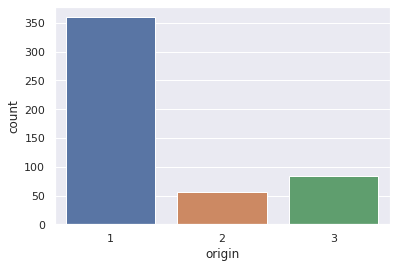

In [133]:
sns.countplot('origin',data=test_data)

<Figure size 720x360 with 0 Axes>

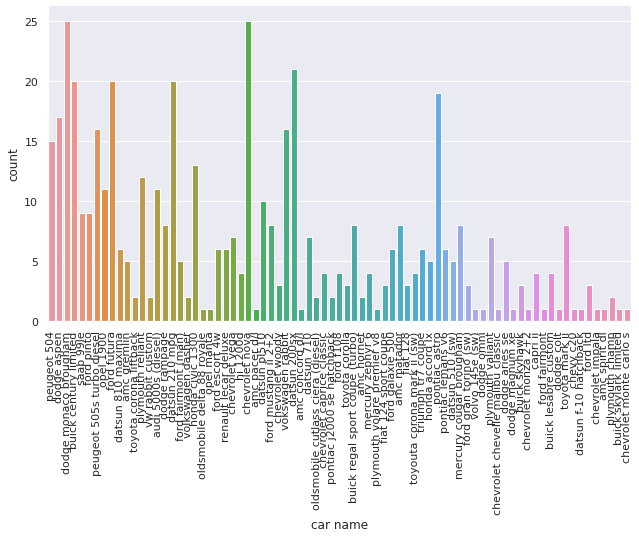

In [134]:
plt.figure(figsize=(10,5))
g = sns.factorplot("car name", data=test_data, aspect=2, kind="count") 
g.set_xticklabels(rotation=90)